#  Problem Statement


### Once a patient seems to have a problem related to tumors, the tumor will be examined and the genetic sequence will be done on the same. From that we get the genes and also the mutations which can cause cancer.

### So every gene has a name  or ID associated with it, so we have gene and variation associated with it.

### Given a Gene ID, variation, a pathologist does research the available literature corresponding to the gene and variation. The pathologist analyzes the text, gene, variations and classify the cancer type.

# Business Objective

### So here we have to build a machine learning model that could classify the cancer type given that Gene, Variation and Text data associated to it.

### The business constraints we have is

### 1. Very Limited Data
### 2. Performance Metric- Multi class log loss

# Exploratory Data Analysis

In [4]:
import pandas as pd
import re
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn
import warnings
import mlxtend
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier



# Reading Data
## Reading Gene and Variation Data

In [6]:
data = pd.read_csv("/content/training_variants")

In [7]:
data.shape

(3321, 4)

In [8]:
data.head()


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [9]:
data_text = pd.read_csv("/content/training_text",sep="\|\|",
                        engine ="python", names=["ID", "TEXT"], skiprows=1)

In [10]:
data_text.shape

(3321, 2)

# Text Preprocessing

In [11]:
# Repalcing multiple spaces in Gene and Variations data
data.Gene = data.Gene.str.replace('\s+', ' ')
data.Variation = data.Variation.str.replace('\s+', ' ')

In [12]:
stop_words= stopwords.words('english')

In [13]:
def text_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string= ""
        total_text = re.sub('[^a-zA-Z0-9\n]',' ', total_text) #replacing every special character with space
        total_text = re.sub('\s+', ' ', total_text) #replacing multiple spaces with single space
        total_text = total_text.lower() # Converting the text to lower case
        for word in total_text.split():
            if not word in stop_words:
                string+=word + " "
        data_text[column][index]=string



In [14]:
for i, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        text_preprocessing(row['TEXT'], i, 'TEXT')
    else:
        print("there is no text for the given id : ", i)



there is no text for the given id :  1109
there is no text for the given id :  1277
there is no text for the given id :  1407
there is no text for the given id :  1639
there is no text for the given id :  2755


In [15]:
data_text.head()

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


## Merging both the dataframes gene variations and text

In [16]:
final_df = pd.merge(data, data_text, on ='ID', how ='left')

In [17]:
final_df.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [18]:
final_df[final_df.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


### Repalcing text that has null values with Gene and variation

In [19]:
final_df.loc[final_df['TEXT'].isnull(), 'TEXT'] =final_df['Gene'] + ' ' + final_df['Variation']

In [20]:
final_df[final_df['ID'].isin([1109,1277,1407,1639,2755])]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations
1407,1407,FGFR3,K508M,6,FGFR3 K508M
1639,1639,FLT1,Amplification,6,FLT1 Amplification
2755,2755,BRAF,G596C,7,BRAF G596C


In [21]:
print(f"Total Unique Genes: {final_df['Gene'].nunique()}")
print(final_df['Gene'].value_counts())

Total Unique Genes: 264
Gene
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
RYBP        1
MDM2        1
CTLA4       1
ARID1A      1
FAM58A      1
Name: count, Length: 264, dtype: int64


From the above results, we see that we have 264 unique genes  and few genes are present only once, so when the data is split, there is a chance that a gene that is present in test data might not be in train data. This could potentially lead to overfitting when this feature is alone used for Classification.

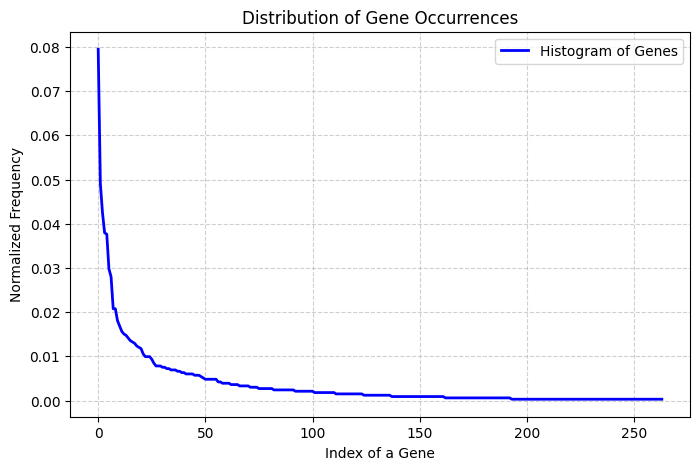

In [22]:
normalized_gene_counts = final_df['Gene'].value_counts().values / final_df['Gene'].value_counts().values.sum()


plt.figure(figsize=(8, 5))
plt.plot(normalized_gene_counts, label="Histogram of Genes", color="b", linewidth=2)


plt.xlabel("Index of a Gene")
plt.ylabel("Normalized Frequency")
plt.title("Distribution of Gene Occurrences")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)


plt.show()

### From the skewed distribution, we say that only very genes have high frequency of occurences, rest all occured only once.

In [23]:
print(f"Total Unique Variations: {final_df['Variation'].nunique()}")
print(final_df['Variation'].value_counts().head(10))

Total Unique Variations: 2996
Variation
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
G12V                     4
Q61L                     3
E17K                     3
T58I                     3
Q61R                     3
Name: count, dtype: int64


### From the above results, we see that we have 2996 variations, and when the data is split, there is chance that a variation that is present in test data might not be in train data. This could potentially lead to overfitting when this feature is alone used for Classification.

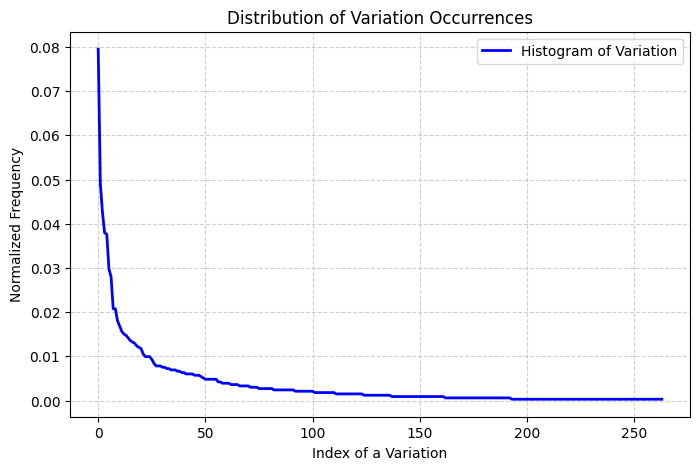

In [24]:
normalized_Variation_counts = final_df['Variation'].value_counts().values / final_df['Variation'].value_counts().values.sum()


plt.figure(figsize=(8, 5))
plt.plot(normalized_gene_counts, label="Histogram of Variation", color="b", linewidth=2)


plt.xlabel("Index of a Variation")
plt.ylabel("Normalized Frequency")
plt.title("Distribution of Variation Occurrences")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)


plt.show()

### The Variations too followed a skewed distribution, we say that only very genes have high frequency of occurences, rest all occured only once.

# Data Preparation

## Train Test split

### Splitting data into train, test and cross validation (64:20:16)

In [25]:
y_true = final_df['Class'].values

#split the data into test and train by maintaining same distribution of output variable 'y_true' [stratify = y_true]
X_train, test_df, y_train, y_test = train_test_split(final_df, y_true, stratify = y_true, test_size = 0.2)
# split the train data into train and cross validation by maintaining same distribution of output variable 'y_trian' [stratify = y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify = y_train, test_size =0.2)

In [26]:
train_df.shape

(2124, 5)

In [27]:
y_train.shape

(2124,)

In [28]:
test_df.shape

(665, 5)

In [29]:
cv_df.shape


(532, 5)

In [30]:
print("Number of data points in train data: ", train_df.shape[0])

Number of data points in train data:  2124


In [31]:
print("NUmber of data points in CV data : ",cv_df.shape[0])
print("NUmber of data points in test data : ",test_df.shape[0])

NUmber of data points in CV data :  532
NUmber of data points in test data :  665


# Distribution of Class labels in train, test, CV datasets.

In [32]:
def get_class_distribution(df):
    class_counts = df['Class'].value_counts().sort_index()
    class_percentage = (class_counts / class_counts.sum()) * 100
    return class_percentage

In [33]:
train_class_distribution = get_class_distribution(train_df)
cv_class_distribution = get_class_distribution(cv_df)
test_class_distribution = get_class_distribution(test_df)

In [34]:
#Plots class distribution as a bar chart.

def plot_class_distribution(class_distribution, dataset_name):
    """Plots the percentage distribution of class labels with value annotations."""
    ax = class_distribution.plot(kind='bar', color='tab:blue', figsize=(8, 5))

    plt.xlabel('Class')
    plt.ylabel('Percentage of Data Points per Class')
    plt.title(f"Percentage Distribution of y_i's in {dataset_name} Data")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, percentage in enumerate(class_distribution):
        plt.text(i, percentage + 0.5, f"{percentage:.2f}%", ha='center', fontsize=12, fontweight='bold')

    plt.show()

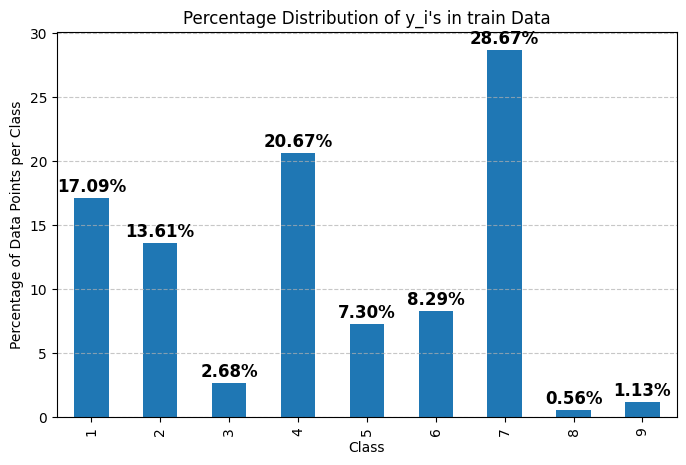

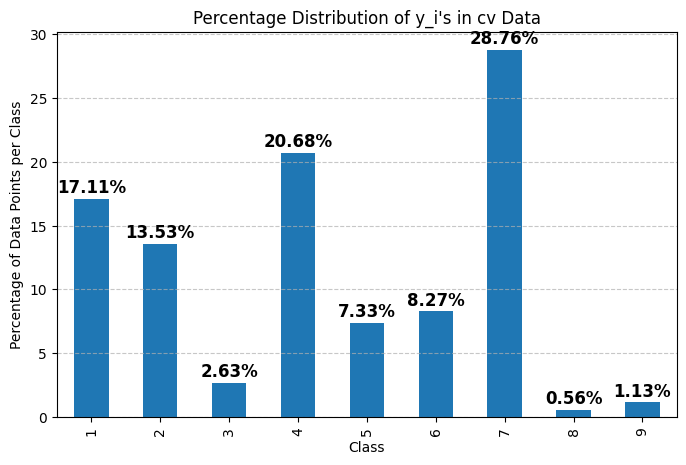

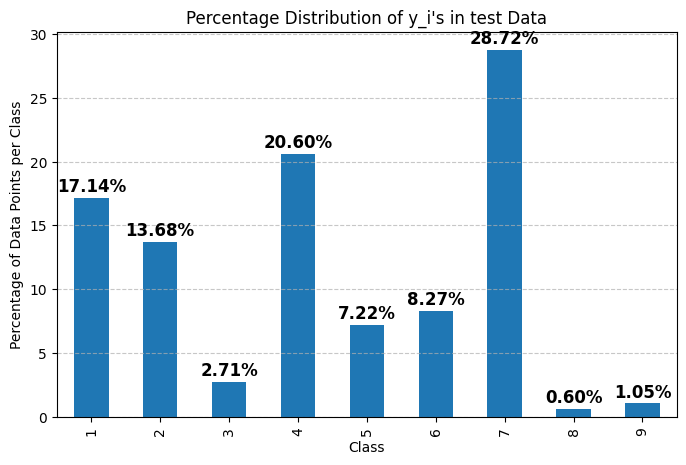

In [35]:
datasets = [("train", train_class_distribution, train_df.shape[0]),
           ("cv", cv_class_distribution, cv_df.shape[0]),
           ("test", test_class_distribution, test_df.shape[0])]

for dataset_name, class_distribution, total_samples in datasets:
    plot_class_distribution(class_distribution, dataset_name)


### From the above plots, the Class label's distribution is same across train, cv and test.

In [36]:
# Defining a function for Confusion Matrix.
def plot_confusion_matrix(test_y,predict_y):
  C= confusion_matrix(test_y, predict_y)

  A=(((C.T)/(C.sum(axis=1))).T)

  B=(C/C.sum(axis=0))

  labels=[1,2,3,4,5,6,7,8,9]

  print("_"*20,"Confusion Matrix", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

  print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

    # representing B in heatmap format
  print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()


# Univariate analysis on Gene Feature


## Categories of Genes and their distribution.

In [37]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
print(unique_genes.head(10))

Number of Unique Genes : 236
Gene
BRCA1     176
TP53      101
EGFR       86
BRCA2      79
PTEN       76
KIT        66
BRAF       57
ALK        50
ERBB2      40
CDKN2A     37
Name: count, dtype: int64


In [38]:
print(unique_genes.shape[0],"different categories of genes are present in data and their distribution as follows")

236 different categories of genes are present in data and their distribution as follows


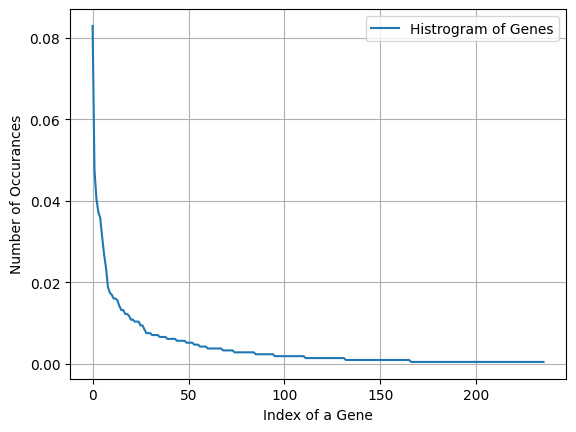

In [39]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

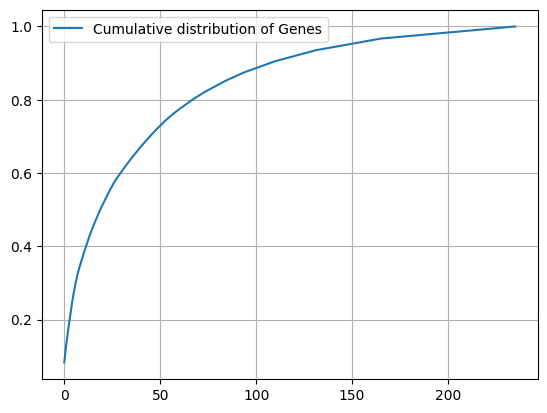

In [40]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

# Featurizing Gene Feature using one hot encoding.

## One hot Encoding of Gene Feature.


In [41]:
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [42]:
train_df['Gene'].head()

,Gene
630,FBXW7
2435,BRCA1
541,SMAD2
1657,FLT3
632,FBXW7


In [43]:
gene_vectorizer.get_feature_names_out()

array(['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc',
       'ar', 'araf', 'arid1a', 'arid1b', 'arid2', 'arid5b', 'asxl1',
       'asxl2', 'atm', 'atr', 'atrx', 'aurka', 'axl', 'b2m', 'bap1',
       'bcl10', 'bcl2l11', 'bcor', 'braf', 'brca1', 'brca2', 'brd4',
       'brip1', 'btk', 'card11', 'carm1', 'casp8', 'cbl', 'ccnd1',
       'ccnd3', 'ccne1', 'cdh1', 'cdk12', 'cdk4', 'cdk6', 'cdkn1a',
       'cdkn1b', 'cdkn2a', 'cdkn2b', 'cebpa', 'chek2', 'crebbp', 'ctcf',
       'ctla4', 'ctnnb1', 'ddr2', 'dicer1', 'dnmt3a', 'dnmt3b', 'egfr',
       'elf3', 'ep300', 'epas1', 'epcam', 'erbb2', 'erbb3', 'erbb4',
       'ercc2', 'ercc3', 'ercc4', 'erg', 'errfi1', 'esr1', 'etv1', 'etv6',
       'ewsr1', 'ezh2', 'fam58a', 'fanca', 'fancc', 'fat1', 'fbxw7',
       'fgf4', 'fgfr1', 'fgfr2', 'fgfr3', 'fgfr4', 'flt3', 'foxa1',
       'foxl2', 'foxo1', 'foxp1', 'gata3', 'gli1', 'gna11', 'gnaq',
       'gnas', 'h3f3a', 'hist1h1c', 'hla', 'hnf1a', 'hras', 'idh1',
       'idh2', 'igf1r', 'i

In [44]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 236)


How many data points in Test and CV datasets are covered by the 220 genes in train dataset?

In [45]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)


Ans
1. In test data 648 out of 665 : 97.44360902255639
2. In cross validation data 510 out of  532 : 95.86466165413535


Variation is a categorical variable, so
how many categories are present?





In [46]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1930
Variation
Truncating Mutations    57
Amplification           50
Deletion                49
Fusions                 18
Q61L                     3
Overexpression           3
G12V                     3
E17K                     3
E330K                    2
T73I                     2
Name: count, dtype: int64


In [47]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1930 different categories of variations in the train data, and they are distibuted as follows


How to featurize this Variation feature ?

We are featurizing this variation feature using One hot encoding




In [48]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [49]:
print("train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature: (2124, 1967)


How many data points in Test and CV datasets are covered by the variations in train dataset?

In [50]:
print(" How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

 How many data points are covered by total  1930  genes in test and cross validation data sets?
Ans
1. In test data 64 out of 665 : 9.624060150375941
2. In cross validation data 64 out of  532 : 12.030075187969924


# Univariate Analysis of Text Feature

## How many unique words present?

In [51]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

Building a CountVectorizer with all the words that occured minimum 3 times in train data

In [52]:
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

train_text_features= text_vectorizer.get_feature_names_out()


train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1


text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52745


Normalizing the features

In [53]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)


test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])

test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)


cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [54]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [55]:
print(Counter(sorted_text_occur))

Counter({3: 5098, 4: 3652, 5: 2714, 6: 2510, 7: 2221, 9: 2006, 8: 1922, 10: 1332, 14: 1188, 12: 1180, 11: 1099, 13: 961, 16: 807, 15: 744, 18: 686, 19: 657, 24: 625, 20: 570, 17: 539, 21: 538, 22: 489, 27: 392, 37: 384, 26: 376, 23: 368, 28: 355, 25: 349, 30: 336, 33: 303, 32: 299, 29: 296, 31: 293, 36: 274, 47: 269, 35: 248, 34: 233, 42: 212, 38: 212, 40: 210, 41: 205, 48: 201, 39: 191, 45: 187, 43: 166, 60: 160, 46: 159, 56: 152, 50: 151, 54: 148, 44: 147, 51: 146, 57: 144, 49: 142, 53: 140, 52: 131, 55: 128, 65: 122, 58: 119, 71: 117, 62: 116, 63: 114, 64: 110, 66: 106, 59: 103, 61: 102, 73: 99, 67: 99, 72: 96, 82: 95, 76: 95, 77: 92, 78: 90, 85: 82, 84: 81, 69: 81, 91: 79, 83: 79, 68: 78, 94: 75, 81: 74, 80: 73, 70: 73, 75: 72, 74: 72, 90: 69, 97: 67, 92: 67, 88: 66, 79: 66, 96: 64, 104: 63, 100: 62, 95: 62, 87: 62, 89: 60, 102: 58, 86: 58, 93: 56, 111: 55, 101: 54, 103: 53, 108: 52, 105: 52, 114: 51, 107: 51, 122: 49, 120: 49, 110: 49, 135: 47, 123: 47, 98: 47, 109: 46, 126: 45, 1

How many words of train data are present in test and CV data?

In [56]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names_out()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [57]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.22 % of word of test data appeared in train data
98.03 % of word of Cross Validation appeared in train data


# Data Preparation

## Gene, Var, text One hot encoded

In [58]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [59]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 54948)
(number of data points * number of features) in test data =  (665, 54948)
(number of data points * number of features) in cross validation data = (532, 54948)


### Vectorizing Text with TFIDF

In [60]:
tfidf_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_tfidf = tfidf_vectorizer.fit_transform(train_df['TEXT'])

train_text_tfidf_features= tfidf_vectorizer.get_feature_names_out()

train_text_fea_counts = train_text_feature_tfidf.sum(axis=0).A1


text_fea_dict = dict(zip(list(train_text_tfidf_features),train_text_fea_counts))

print(f"TF-IDF transformation completed. Vocabulary size: {len(train_text_tfidf_features)}")



TF-IDF transformation completed. Vocabulary size: 52745


In [61]:

cv_text_feature_tfidf = tfidf_vectorizer.transform(cv_df['TEXT'])

test_text_feature_tfidf = tfidf_vectorizer.transform(test_df['TEXT'])


train_text_feature_tfidf = normalize(train_text_feature_tfidf, axis=0)

cv_text_feature_tfidf = normalize(cv_text_feature_tfidf, axis =0)

test_text_feature_tfidf = normalize(test_text_feature_tfidf, axis =0)

In [62]:
train_x_tfidf = hstack((train_gene_var_onehotCoding,train_text_feature_tfidf )).tocsr()
train_y = np.array(list(train_df['Class']))

cv_tfidf = hstack((cv_gene_var_onehotCoding,cv_text_feature_tfidf )).tocsr()
cv_y = np.array(list(cv_df['Class']))

test_tfidf = hstack((test_gene_var_onehotCoding,test_text_feature_tfidf)).tocsr()
test_y = np.array(list(test_df['Class']))

In [63]:
print("Tfidf features :")
print("(number of data points * number of features) in train data = ", train_x_tfidf.shape)
print("(number of data points * number of features) in cross validation data = ", cv_tfidf.shape)
print("(number of data points * number of features) in test data =", test_tfidf.shape)

Tfidf features :
(number of data points * number of features) in train data =  (2124, 54948)
(number of data points * number of features) in cross validation data =  (532, 54948)
(number of data points * number of features) in test data = (665, 54948)


### Vectorizing text with max features 1000.

In [64]:

tfidf_vectorizer_maxft = TfidfVectorizer(max_features = 1000, min_df =3)
train_text_feature_tfidf_maxft = tfidf_vectorizer_maxft.fit_transform(train_df['TEXT'])
train_text_features_tfidf_max_features = tfidf_vectorizer_maxft.get_feature_names_out()
train_text_fea_max_ft_counts = train_text_feature_tfidf_maxft.sum(axis=0).A1
text_fea_dict_max_ft = dict(zip(list(train_text_features_tfidf_max_features), train_text_fea_max_ft_counts))
print("Total number of unique words in train data :", len(train_text_features_tfidf_max_features))


Total number of unique words in train data : 1000


In [65]:
cv_text_feature_tfidf_maxft = tfidf_vectorizer_maxft.transform(cv_df['TEXT'])
test_text_feature_tfidf_maxft = tfidf_vectorizer_maxft.transform(test_df['TEXT'])
train_text_feature_tfidf_maxft = normalize(train_text_feature_tfidf_maxft, axis =0)
cv_text_feature_tfidf_maxft = normalize(cv_text_feature_tfidf_maxft, axis =0)
test_text_feature_tfidf_maxft = normalize(test_text_feature_tfidf_maxft, axis =0)

In [66]:
train_x_tfidf_maxft = hstack((train_gene_var_onehotCoding,train_text_feature_tfidf_maxft )).tocsr()
train_y = np.array(list(train_df['Class']))

cv_tfidf_maxft = hstack((cv_gene_var_onehotCoding,cv_text_feature_tfidf_maxft)).tocsr()
cv_y = np.array(list(cv_df['Class']))

test_tfidf_maxft = hstack((test_gene_var_onehotCoding,test_text_feature_tfidf_maxft)).tocsr()
test_y = np.array(list(test_df['Class']))

In [67]:
print("Tfidf Max_1000 features :")
print("(number of data points * number of features) in train data = ", train_x_tfidf_maxft.shape)
print("(number of data points * number of features) in cross validation data = ", cv_tfidf_maxft.shape)
print("(number of data points * number of features) in test data =", test_tfidf_maxft.shape)

Tfidf Max_1000 features :
(number of data points * number of features) in train data =  (2124, 3203)
(number of data points * number of features) in cross validation data =  (532, 3203)
(number of data points * number of features) in test data = (665, 3203)


# Machine Learning Models

In [68]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we will provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [69]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

# Logistic Regresssion

## With class balancing

# Hyper parameter tuning

for alpha = 1e-06
Log Loss : 1.3219580670301372
for alpha = 1e-05
Log Loss : 1.2665103733279968
for alpha = 0.0001
Log Loss : 1.069367328956637
for alpha = 0.001
Log Loss : 1.0269279537644669
for alpha = 0.01
Log Loss : 1.09316186966971
for alpha = 0.1
Log Loss : 1.441437670257309
for alpha = 1
Log Loss : 1.6836857390257338
for alpha = 10
Log Loss : 1.7137271074302773
for alpha = 100
Log Loss : 1.7167456371669707


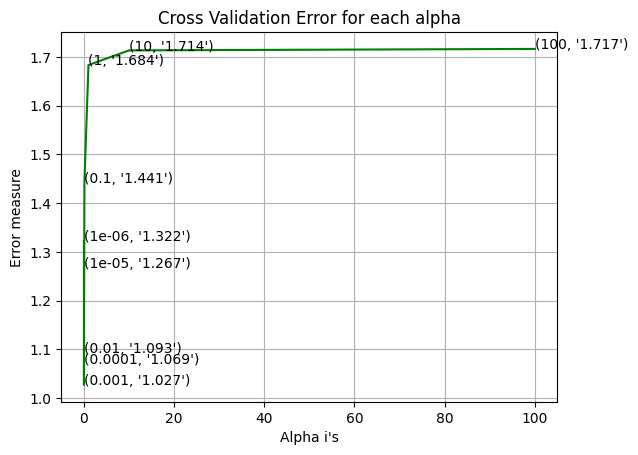

For Train data with alpha=3, Log Loss: 0.5256505787231861
For Cross Validation data with alpha=3, Log Loss: 1.0269279537644669
For Test data with alpha=3, Log Loss: 1.156083973558178


In [70]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)
    print("Log Loss :",log_loss_value)



fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_onehotCoding, train_y),
                           ("Cross Validation", cv_x_onehotCoding, cv_y),
                           ("Test", test_x_onehotCoding, y_test)]:

    predict_y = sig_clf.predict_proba(X)

    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.0974629530003357
Number of mis-classified points : 0.3518796992481203
____________________ Confusion Matrix --------------------


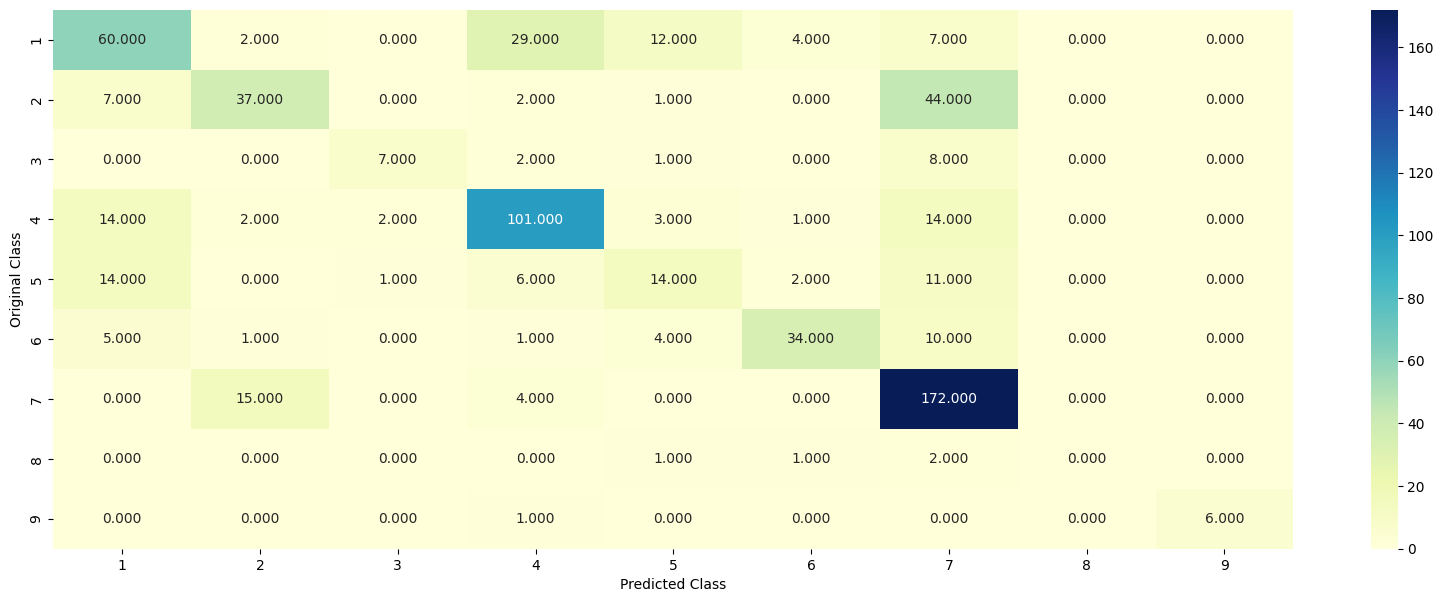

-------------------- Precision matrix (Columm Sum=1) --------------------


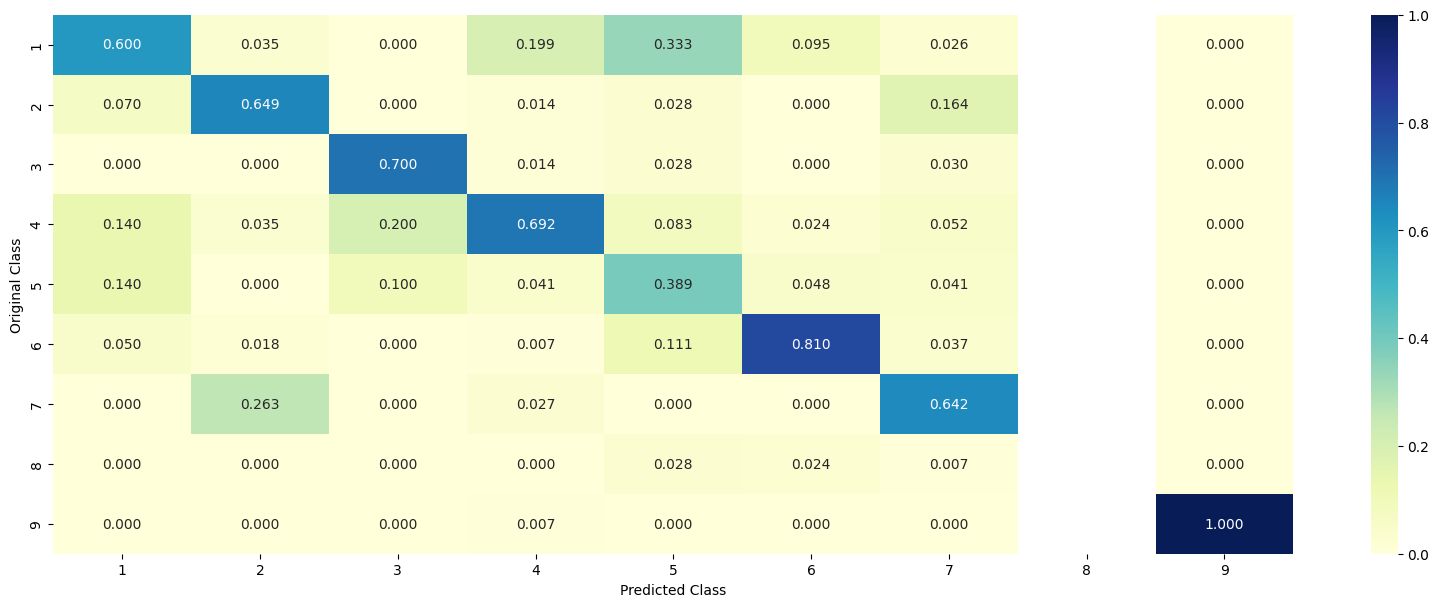

-------------------- Recall matrix (Row sum=1) --------------------


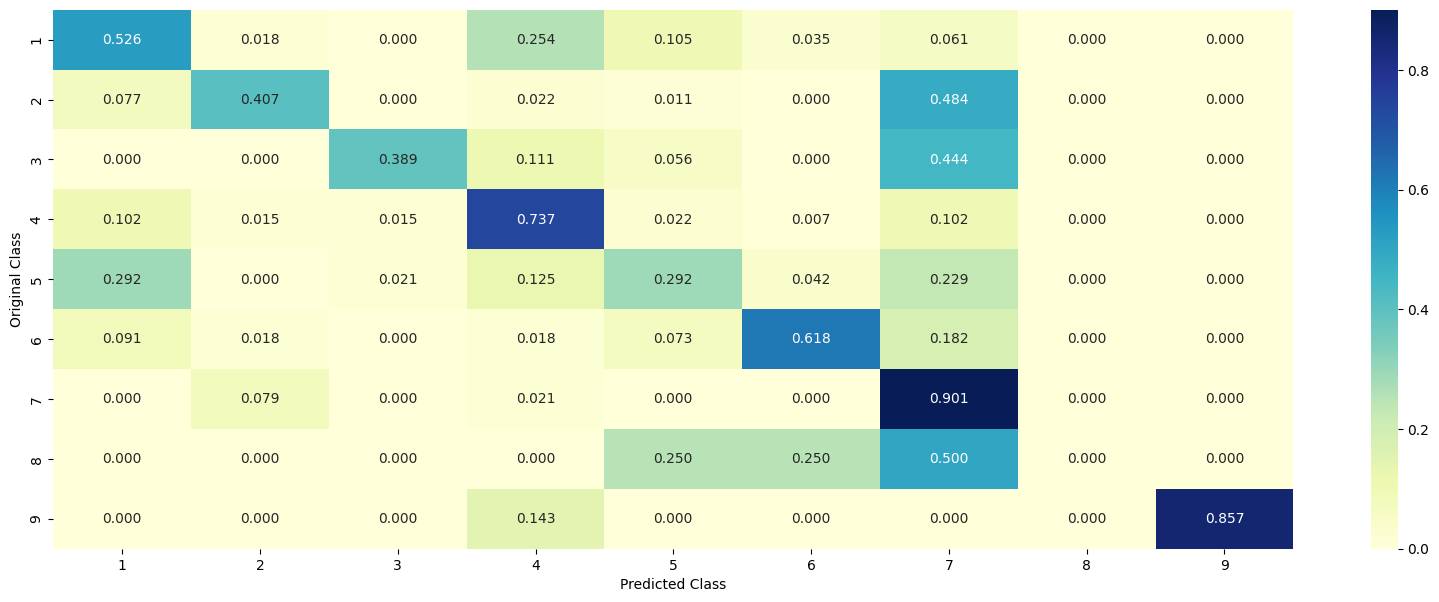

In [87]:
# Testing the model with best hyper paramters

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, test_x_onehotCoding, test_y, clf)

In [71]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)

    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])

    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_count_vec.get_feature_names_out())

    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names_out()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names_out()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names_out()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")


In [72]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most important features are present in our query point")
    print("-"*50)
    print("The features that are most important of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [76]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 10
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)


Predicted Class : 6
Predicted Class Probabilities: [[0.0066 0.005  0.0016 0.0053 0.1588 0.8147 0.0019 0.0047 0.0014]]
Actual Class : 6
--------------------------------------------------


In [80]:
# Incorrectly Classified point

test_point_index = 22
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)


Predicted Class : 7
Predicted Class Probabilities: [[0.1174 0.2122 0.0143 0.0558 0.067  0.0302 0.4874 0.0097 0.0061]]
Actual Class : 2
--------------------------------------------------


# With TFIDF Features

For alpha = 1e-06
Log Loss: 1.2444759424259761
For alpha = 1e-05
Log Loss: 1.191484744752461
For alpha = 0.0001
Log Loss: 0.9955183987993094
For alpha = 0.001
Log Loss: 0.9835332064167679
For alpha = 0.01
Log Loss: 1.0544503303462933
For alpha = 0.1
Log Loss: 1.2205555022186247
For alpha = 1
Log Loss: 1.4168752096857928
For alpha = 10
Log Loss: 1.453960562175371
For alpha = 100
Log Loss: 1.4582171923664422


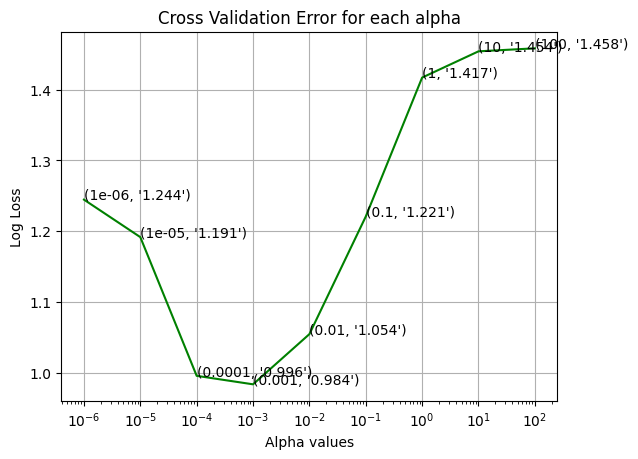

Best Alpha: 0.001
For Train data with alpha=0.001, Log Loss: 0.49569912819904943
For Cross Validation data with alpha=0.001, Log Loss: 0.9835332064167679
For Test data with alpha=0.001, Log Loss: 1.1189317647109984


In [81]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Log Loss
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf)

    # Clip probabilities to prevent log(0) errors
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)

    # Compute Log Loss
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

#Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]


print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf, train_y),
                           ("Cross Validation", cv_tfidf, cv_y),
                           ("Test", test_tfidf, y_test)]:

    predict_y = sig_clf.predict_proba(X)
    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)  # Avoid log(0) error

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.1189317647109984
Number of mis-classified points : 0.3699248120300752
____________________ Confusion Matrix --------------------


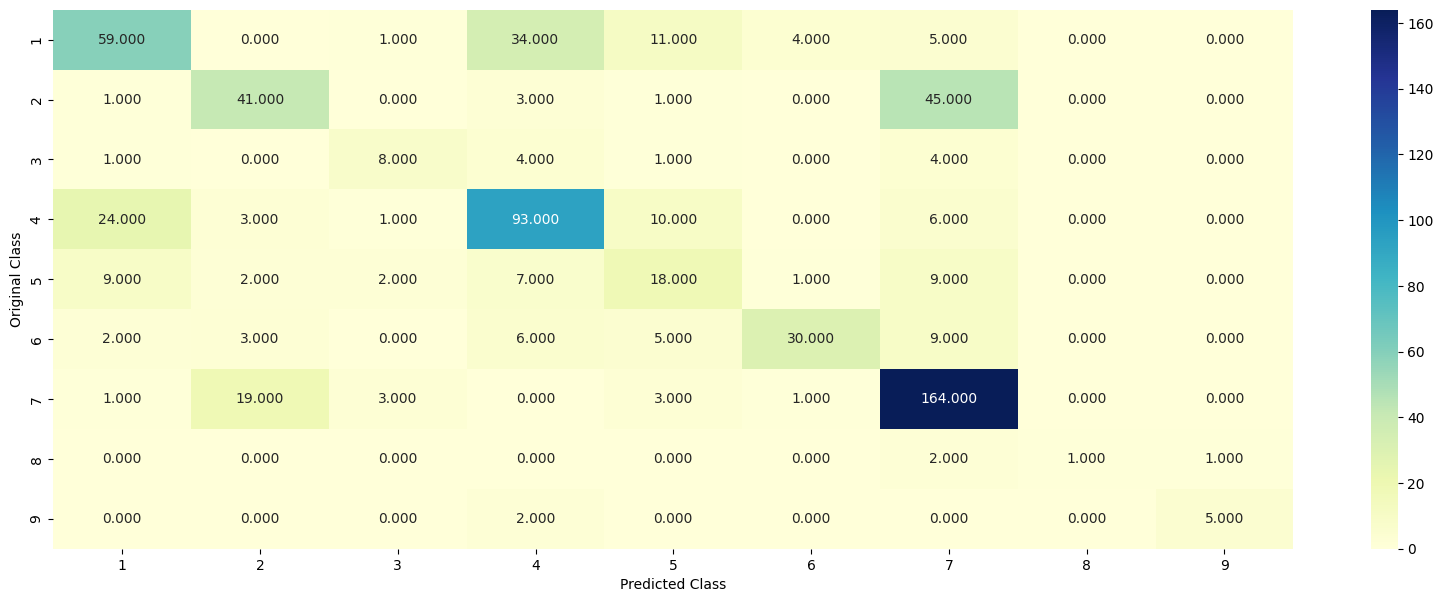

-------------------- Precision matrix (Columm Sum=1) --------------------


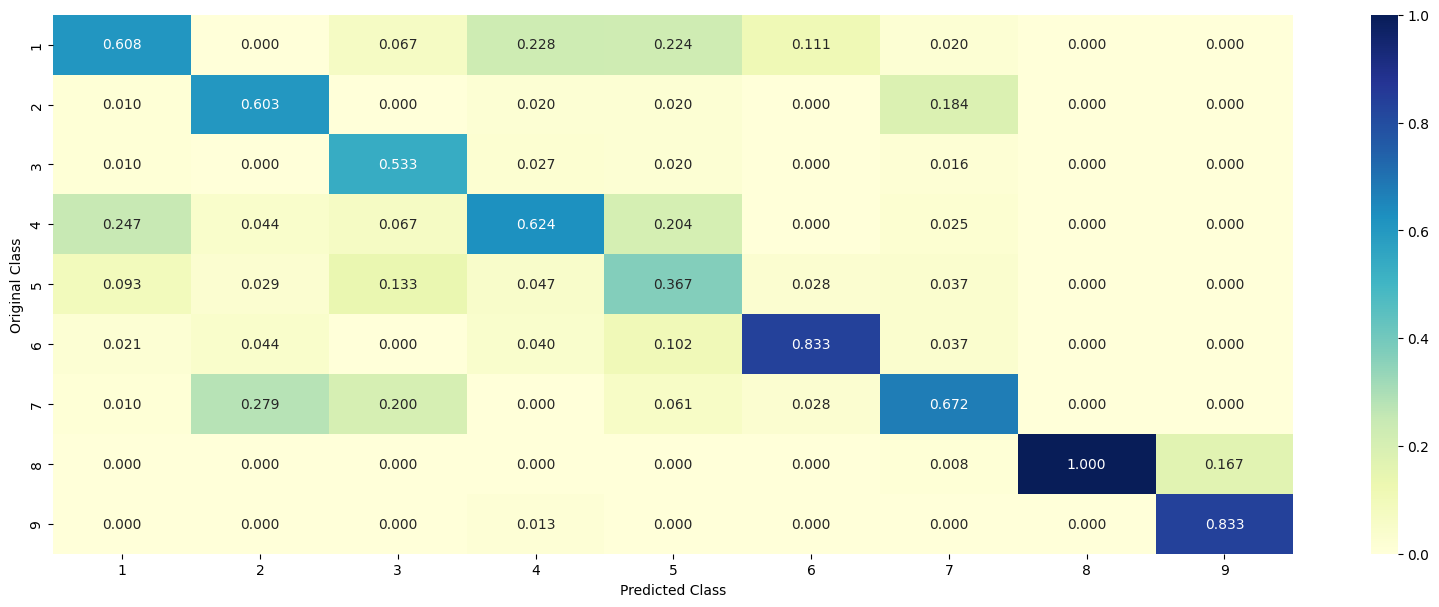

-------------------- Recall matrix (Row sum=1) --------------------


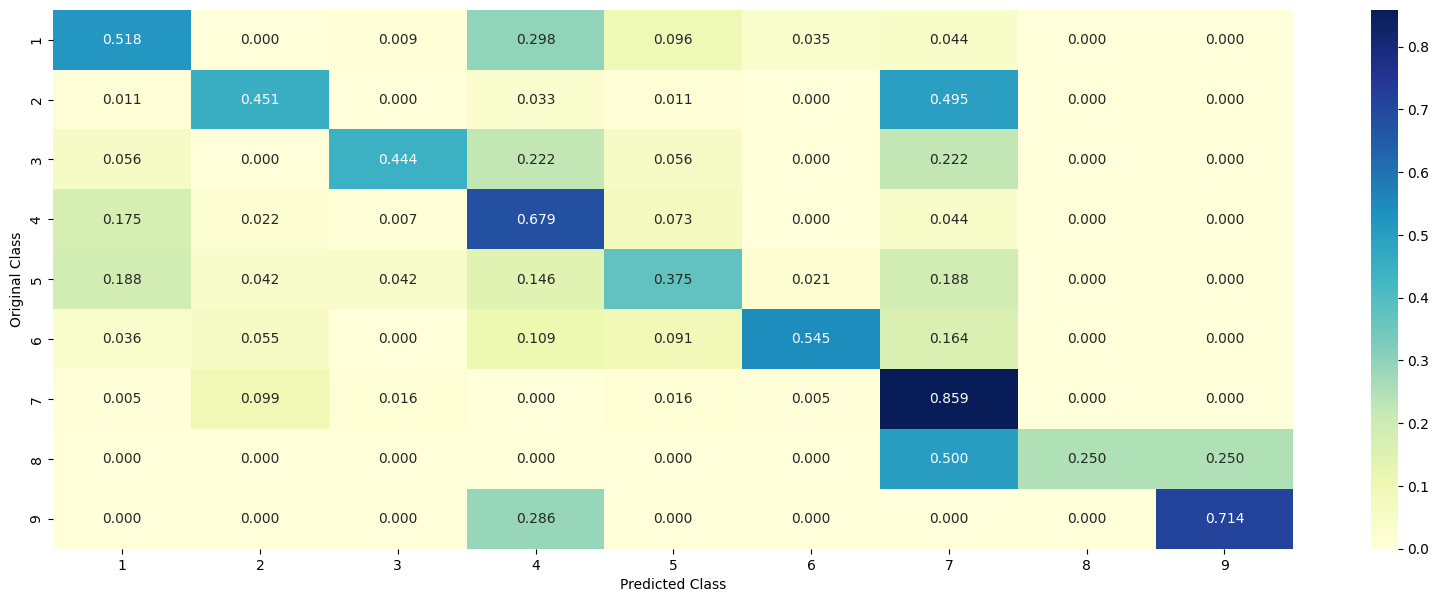

In [82]:
clf = SGDClassifier(class_weight='balanced',alpha = alpha[best_alpha_idx], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_tfidf, test_y, clf)

### TFIDF with top 1000 features


For alpha = 1e-06
Log Loss: 1.0931227586148742
For alpha = 1e-05
Log Loss: 1.001178295002722
For alpha = 0.0001
Log Loss: 0.963209733084369
For alpha = 0.001
Log Loss: 0.9836329992047709
For alpha = 0.01
Log Loss: 1.1666247026522676
For alpha = 0.1
Log Loss: 1.6013304189123128
For alpha = 1
Log Loss: 1.7338289794105406
For alpha = 10
Log Loss: 1.7492498328898771
For alpha = 100
Log Loss: 1.7509522106128508


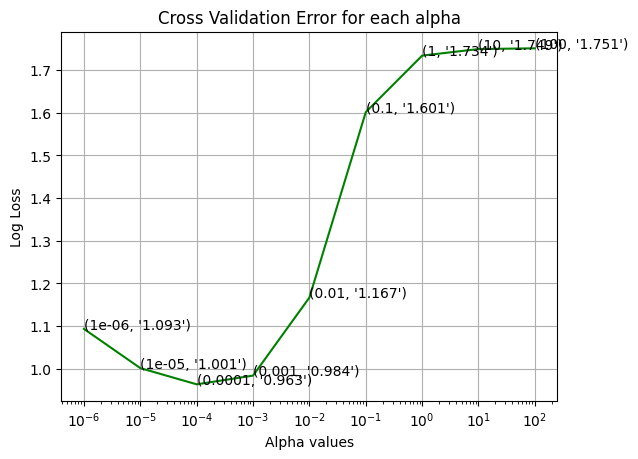

Best Alpha: 0.0001
For Train data with alpha=0.0001, Log Loss: 0.4056620842656339
For Cross Validation data with alpha=0.0001, Log Loss: 0.963209733084369
For Test data with alpha=0.0001, Log Loss: 1.0565862270498563


In [84]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Log Loss
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf_maxft, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf_maxft, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_maxft)

    # Clip probabilities to prevent log(0) errors
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)

    # Compute Log Loss
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

#Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]


print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf_maxft, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf_maxft, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf_maxft, train_y),
                           ("Cross Validation", cv_tfidf_maxft, cv_y),
                           ("Test", test_tfidf_maxft, y_test)]:

    predict_y = sig_clf.predict_proba(X)
    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)  # Avoid log(0) error

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.0565862270498563
Number of mis-classified points : 0.35037593984962406
____________________ Confusion Matrix --------------------


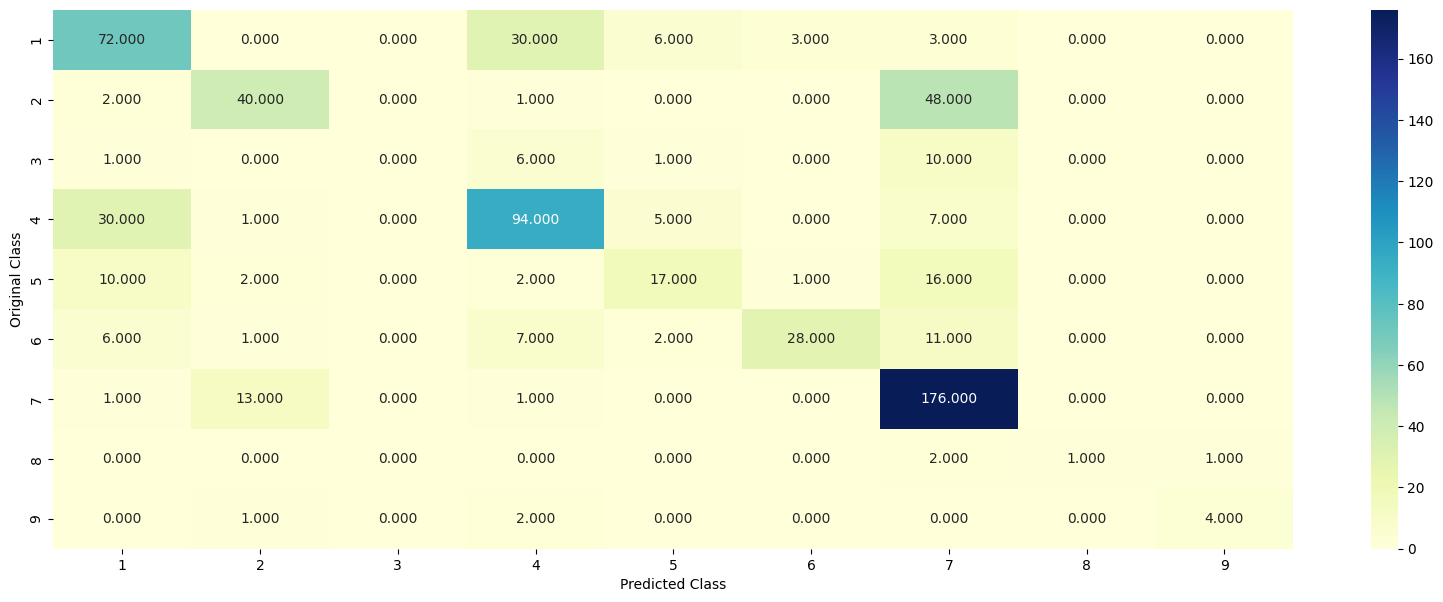

-------------------- Precision matrix (Columm Sum=1) --------------------


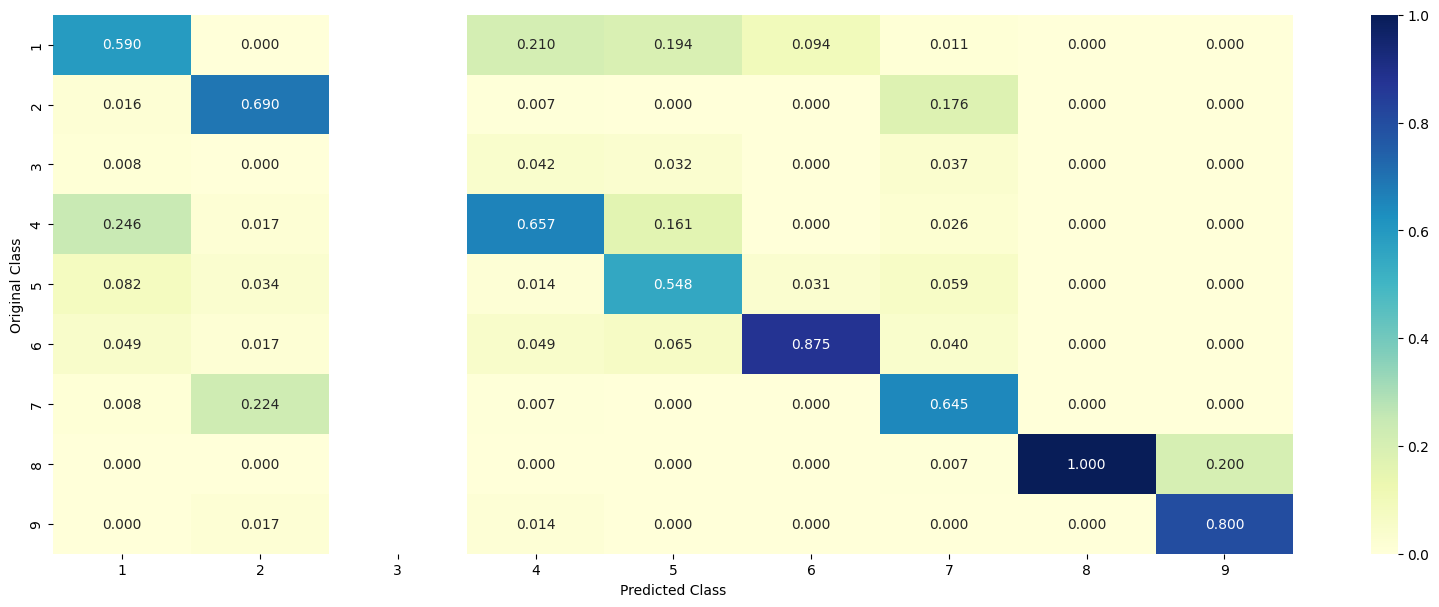

-------------------- Recall matrix (Row sum=1) --------------------


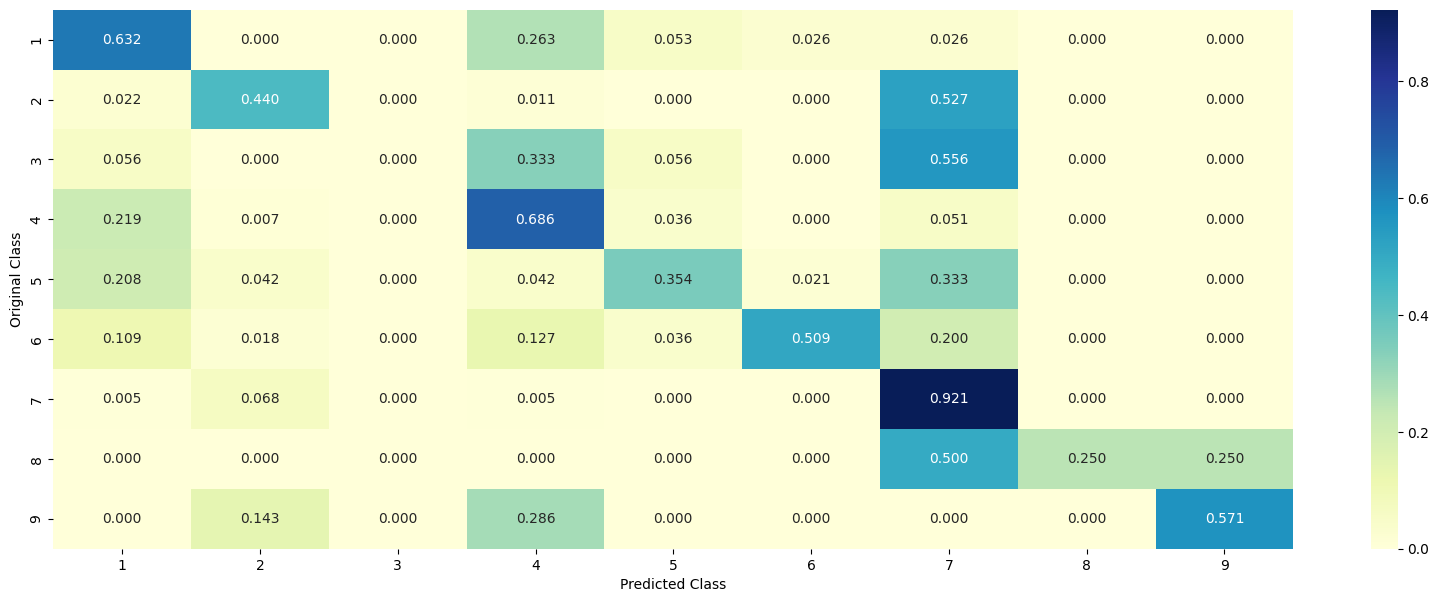

In [85]:
clf = SGDClassifier(class_weight='balanced',alpha = alpha[best_alpha_idx], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf_maxft, train_y, test_tfidf_maxft, test_y, clf)

## Without Class balancing

for alpha = 1e-06
Log Loss : 1.286664807224015
for alpha = 1e-05
Log Loss : 1.2263997895402052
for alpha = 0.0001
Log Loss : 1.066993441642944
for alpha = 0.001
Log Loss : 1.0384631629332104
for alpha = 0.01
Log Loss : 1.1405760674483176
for alpha = 0.1
Log Loss : 1.3118370143755191
for alpha = 1
Log Loss : 1.5624924830801374
for alpha = 10
Log Loss : 1.6130485513565611
for alpha = 100
Log Loss : 1.618609905628532


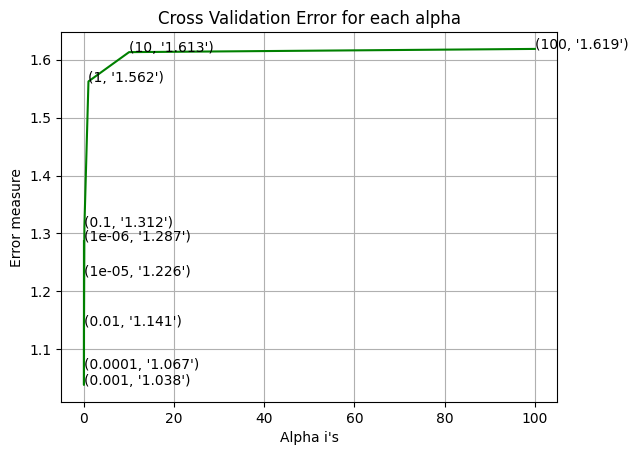

For Train data with alpha=3, Log Loss: 0.5256505787231861
For Cross Validation data with alpha=3, Log Loss: 1.0269279537644669
For Test data with alpha=3, Log Loss: 1.156083973558178


In [88]:
# Hyper parameter tuning

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)
    print("Log Loss :",log_loss_value)



fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_onehotCoding, train_y),
                           ("Cross Validation", cv_x_onehotCoding, cv_y),
                           ("Test", test_x_onehotCoding, y_test)]:

    predict_y = sig_clf.predict_proba(X)

    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")


Log loss : 1.0384631629332104
Number of mis-classified points : 0.32894736842105265
____________________ Confusion Matrix --------------------


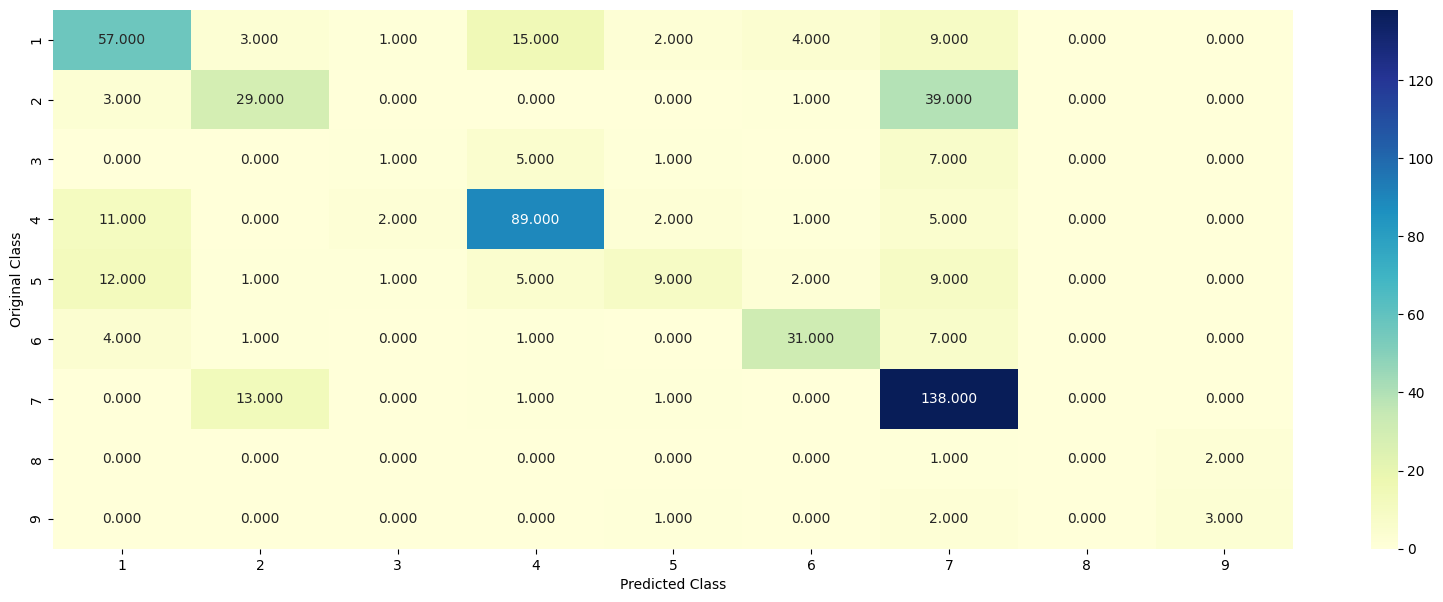

-------------------- Precision matrix (Columm Sum=1) --------------------


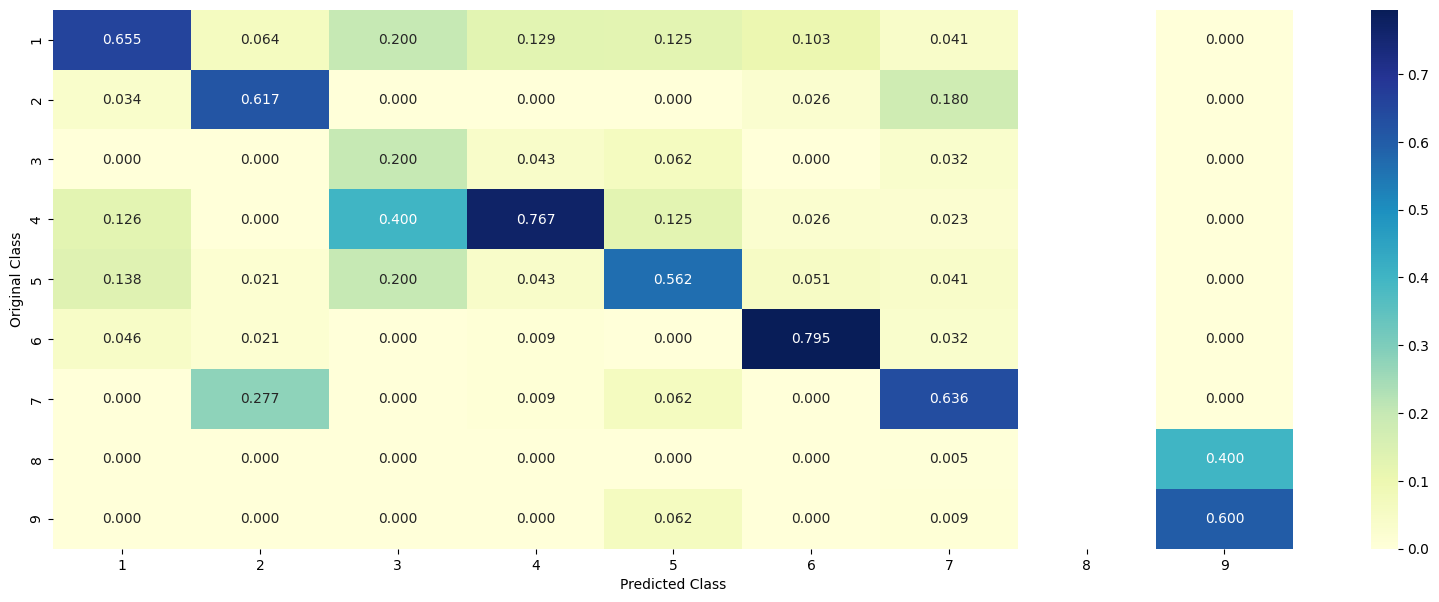

-------------------- Recall matrix (Row sum=1) --------------------


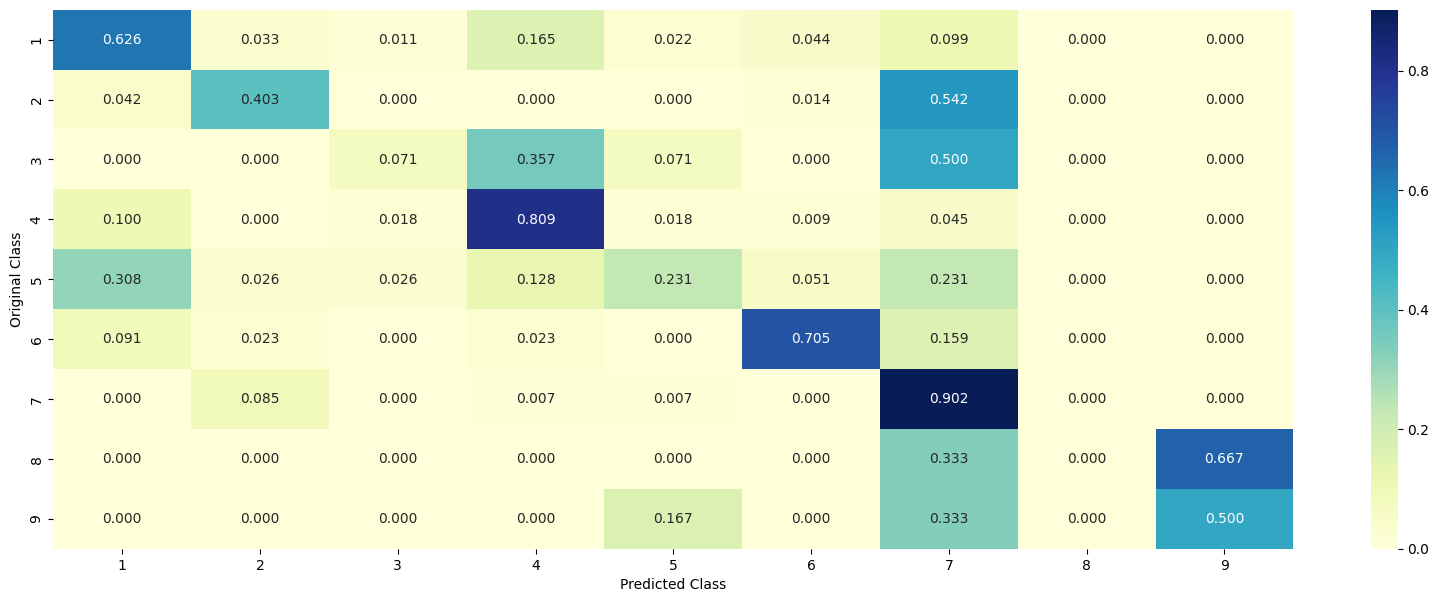

In [90]:
# Testing the model with  best hyper parameters

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [96]:

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 10
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]



Predicted Class : 6
Predicted Class Probabilities: [[0.0066 0.005  0.0016 0.0053 0.1588 0.8147 0.0019 0.0047 0.0014]]
Actual Class : 6


In [102]:
test_point_index = 8
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]



Predicted Class : 7
Predicted Class Probabilities: [[0.0779 0.1497 0.0099 0.0649 0.0317 0.0187 0.6353 0.0072 0.0047]]
Actual Class : 2


### Tfidf text features

For alpha = 1e-06
Log Loss: 1.1980713150133315
For alpha = 1e-05
Log Loss: 1.163487375808009
For alpha = 0.0001
Log Loss: 1.012382320412291
For alpha = 0.001
Log Loss: 1.0006435760963688
For alpha = 0.01
Log Loss: 1.0996961244888468
For alpha = 0.1
Log Loss: 1.1962256834990685
For alpha = 1
Log Loss: 1.3713647526193464
For alpha = 10
Log Loss: 1.4218186220284643
For alpha = 100
Log Loss: 1.4277288384324693


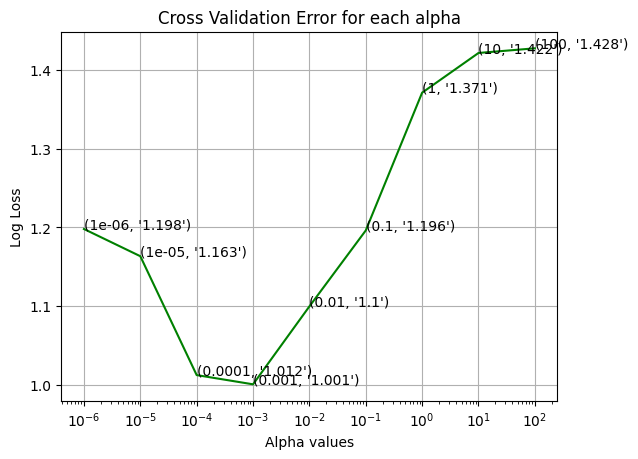

Best Alpha: 0.001
For Train data with alpha=0.001, Log Loss: 0.49569912819904943
For Cross Validation data with alpha=0.001, Log Loss: 0.9835332064167679
For Test data with alpha=0.001, Log Loss: 1.1189317647109984


In [103]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Log Loss
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf)

    # Clip probabilities to prevent log(0) errors
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)

    # Compute Log Loss
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

#Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]


print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf, train_y),
                           ("Cross Validation", cv_tfidf, cv_y),
                           ("Test", test_tfidf, y_test)]:

    predict_y = sig_clf.predict_proba(X)
    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)  # Avoid log(0) error

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 0.9835332064167679
Number of mis-classified points : 0.34022556390977443
____________________ Confusion Matrix --------------------


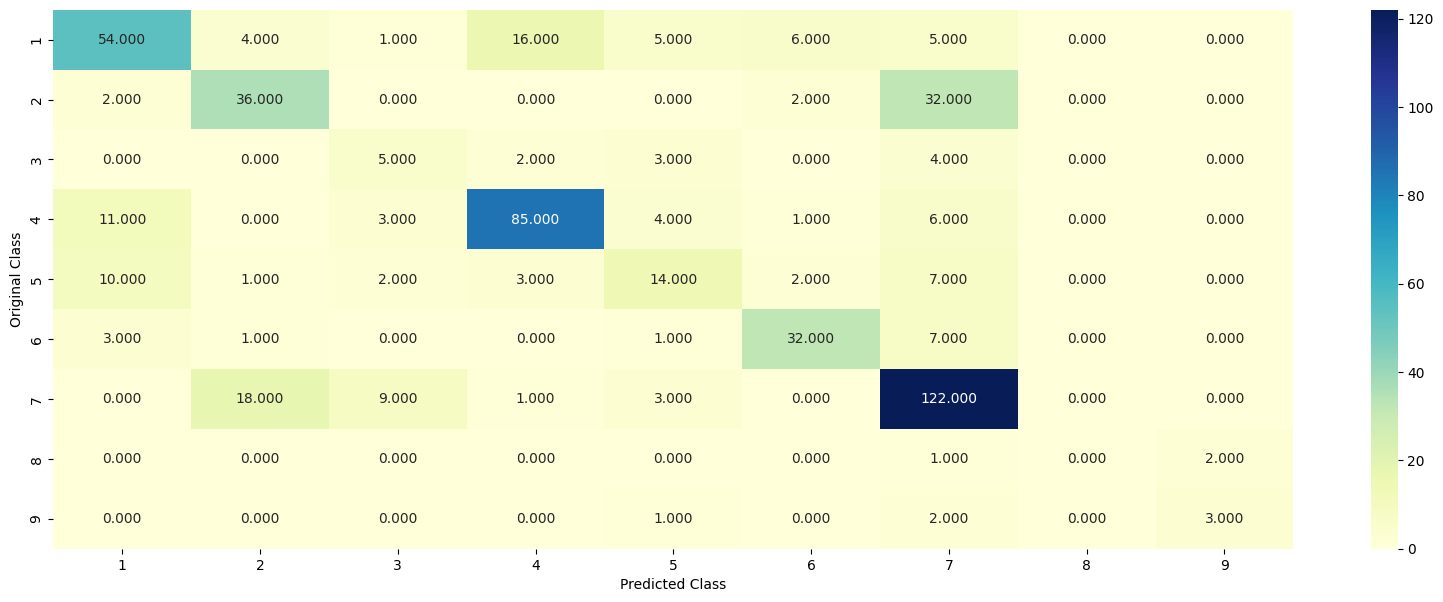

-------------------- Precision matrix (Columm Sum=1) --------------------


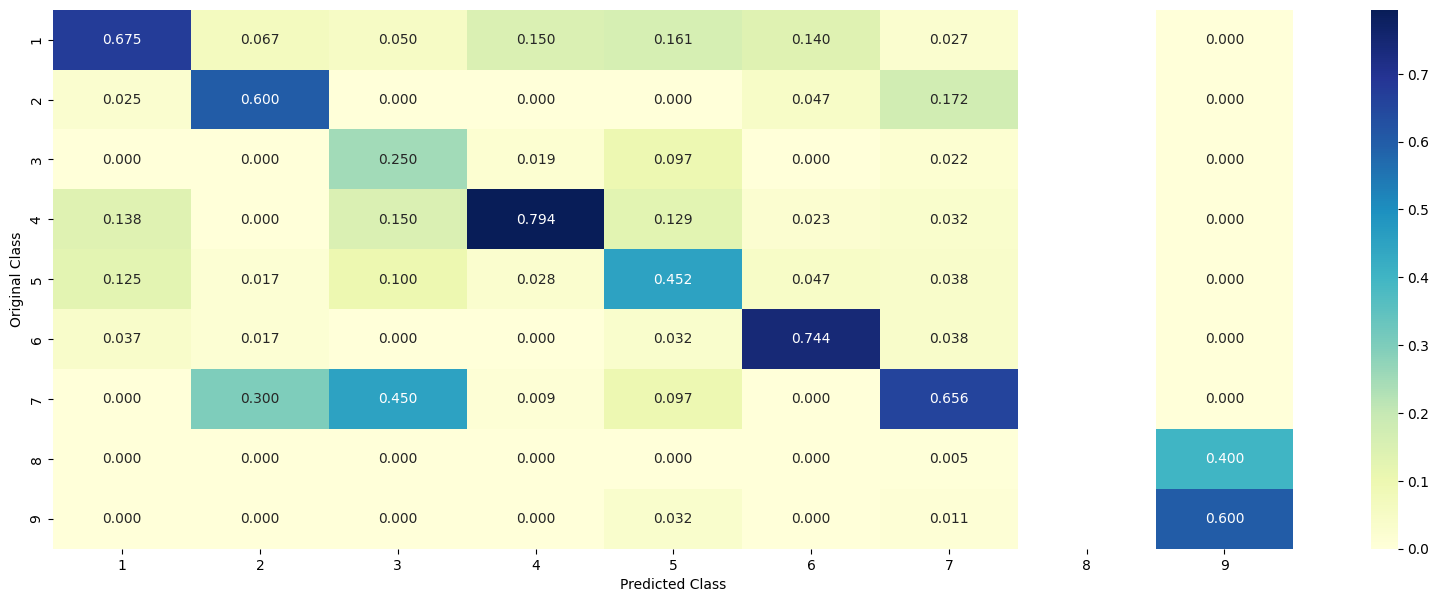

-------------------- Recall matrix (Row sum=1) --------------------


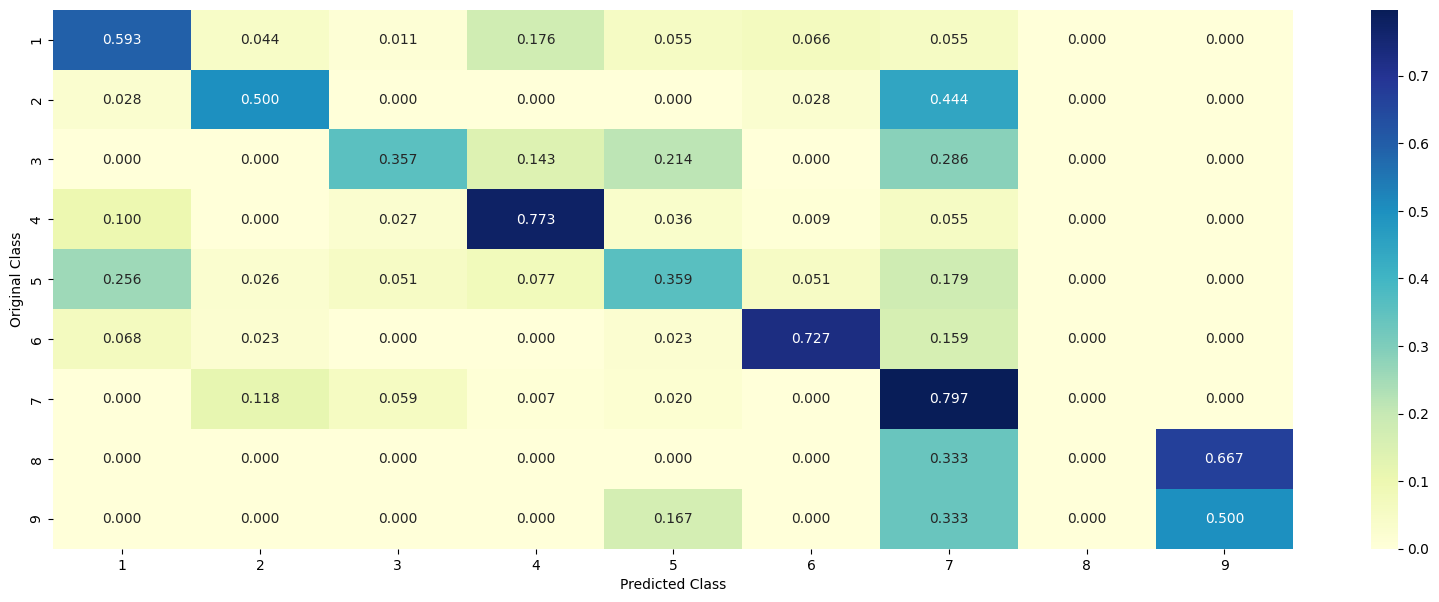

In [105]:
clf = SGDClassifier(class_weight='balanced',alpha = alpha[best_alpha_idx], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, cv_tfidf, cv_y, clf)

### TFIDF with top 1000 features

For alpha = 1e-06
Log Loss: 1.113352937388083
For alpha = 1e-05
Log Loss: 1.0411828724655419
For alpha = 0.0001
Log Loss: 1.0010165645509546
For alpha = 0.001
Log Loss: 1.0864765217936847
For alpha = 0.01
Log Loss: 1.297153507900801
For alpha = 0.1
Log Loss: 1.5671721848339344
For alpha = 1
Log Loss: 1.6781441565713777
For alpha = 10
Log Loss: 1.6949812532748008
For alpha = 100
Log Loss: 1.6969116742920143


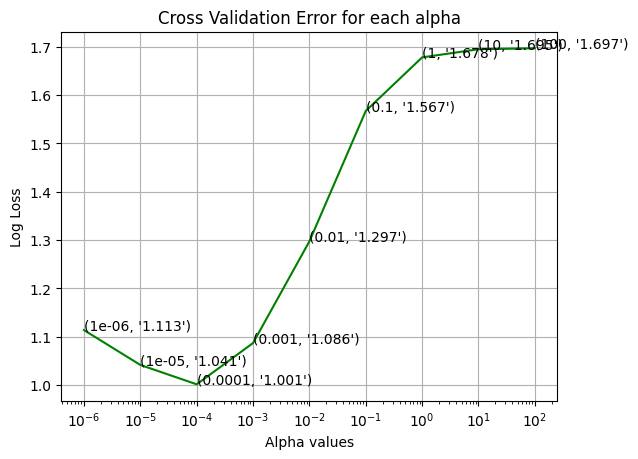

Best Alpha: 0.0001
For Train data with alpha=0.0001, Log Loss: 0.4056620842656339
For Cross Validation data with alpha=0.0001, Log Loss: 0.963209733084369
For Test data with alpha=0.0001, Log Loss: 1.0565862270498563


In [106]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Log Loss
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf_maxft, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf_maxft, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_maxft)

    # Clip probabilities to prevent log(0) errors
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)

    # Compute Log Loss
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

#Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]


print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf_maxft, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf_maxft, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf_maxft, train_y),
                           ("Cross Validation", cv_tfidf_maxft, cv_y),
                           ("Test", test_tfidf_maxft, y_test)]:

    predict_y = sig_clf.predict_proba(X)
    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)  # Avoid log(0) error

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.0838149111766422
Number of mis-classified points : 0.3609022556390977
____________________ Confusion Matrix --------------------


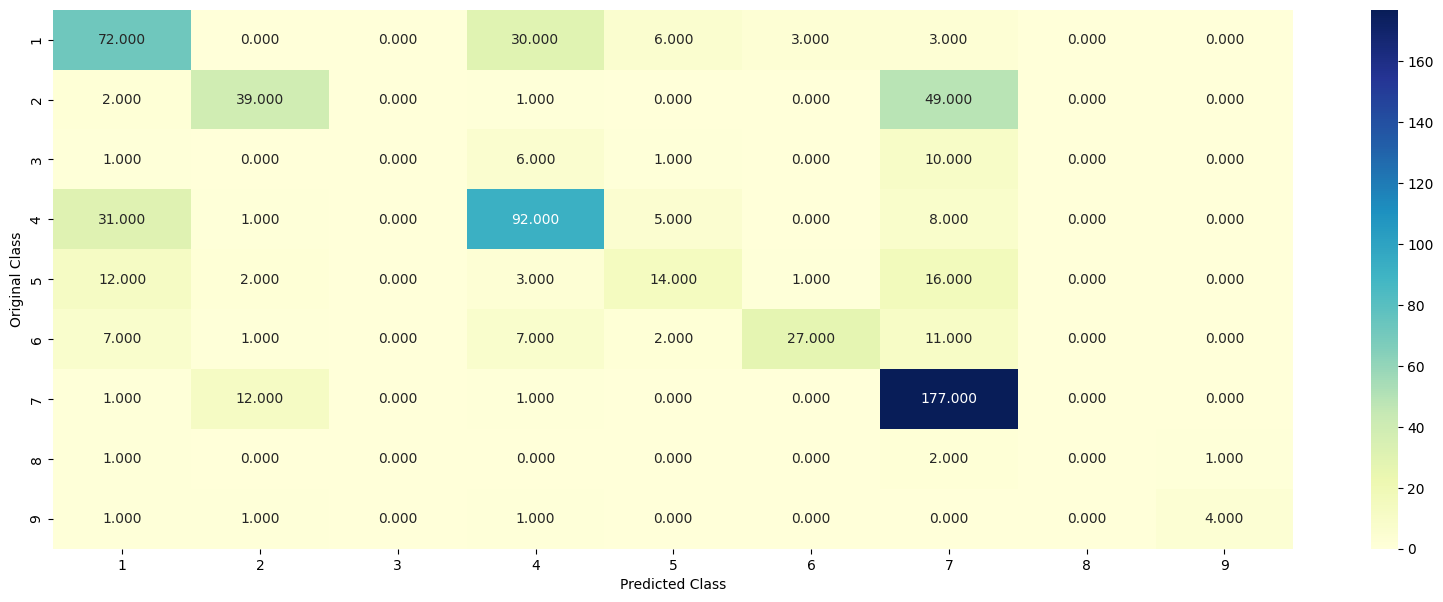

-------------------- Precision matrix (Columm Sum=1) --------------------


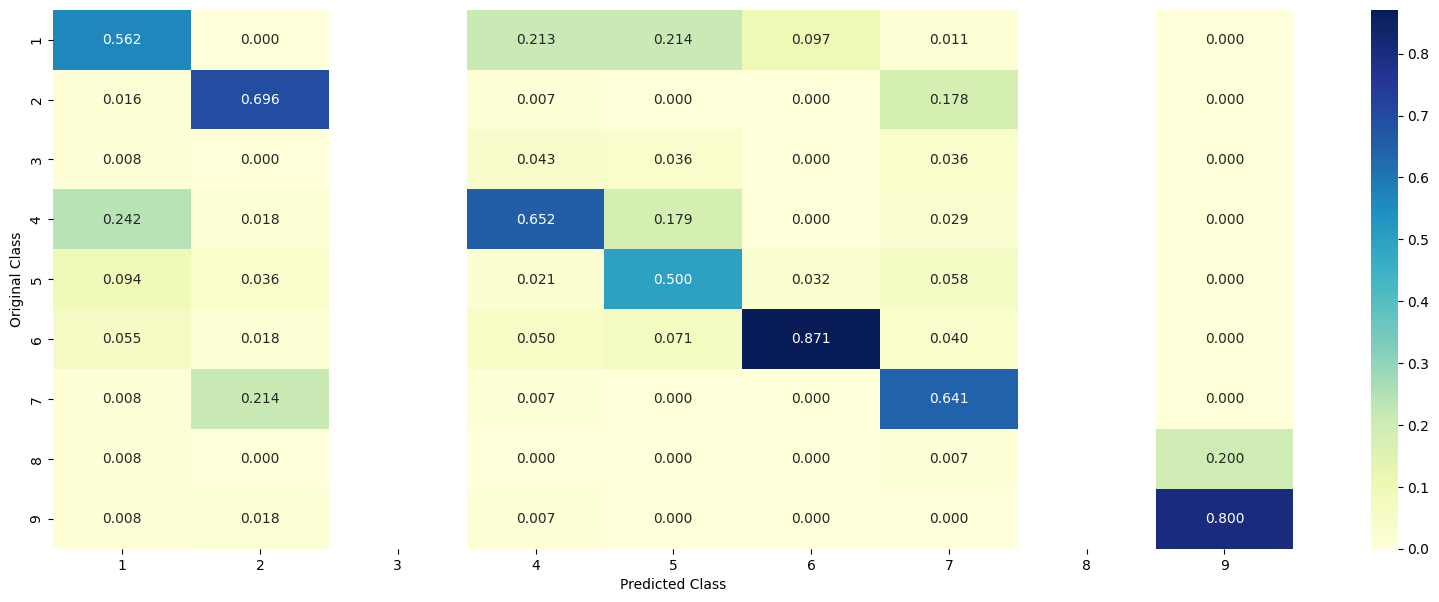

-------------------- Recall matrix (Row sum=1) --------------------


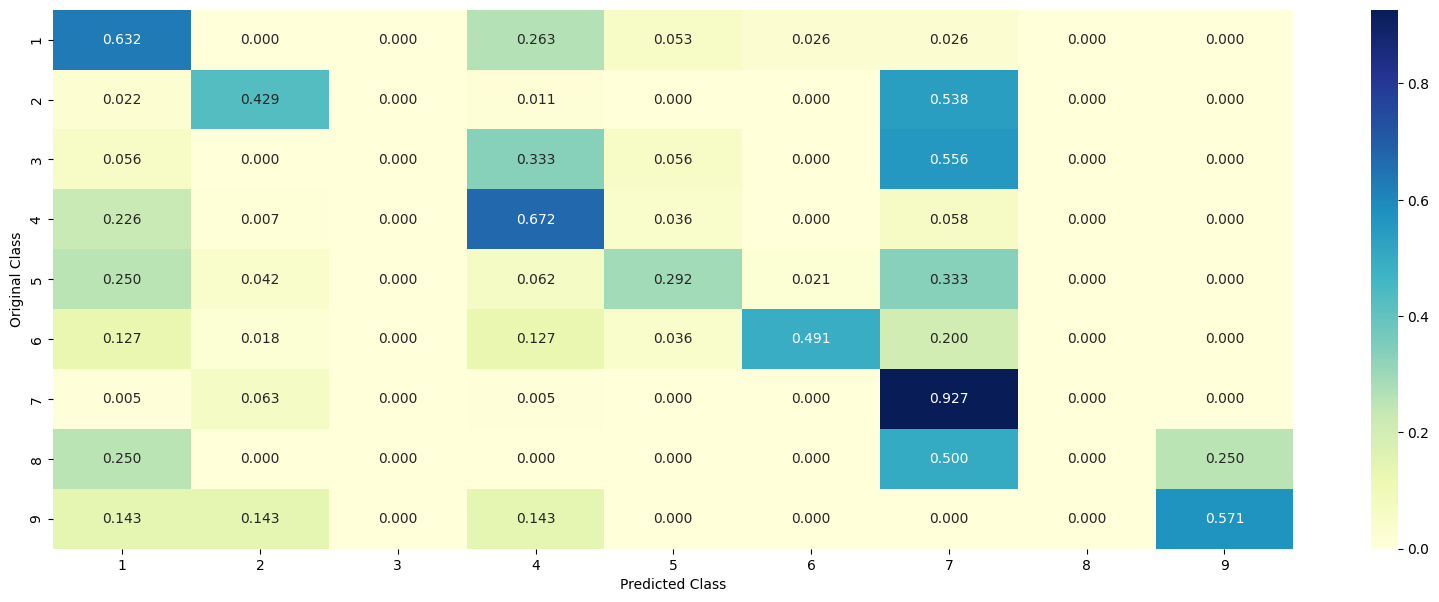

In [107]:
clf = SGDClassifier(alpha = alpha[best_alpha_idx], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf_maxft, train_y, test_tfidf_maxft, test_y, clf)

# Support Vector Machines

For alpha = 1e-05
Log Loss: 1.2875502106614354
For alpha = 0.0001
Log Loss: 1.1996272298863846
For alpha = 0.001
Log Loss: 1.0944006910378965
For alpha = 0.01
Log Loss: 1.120279246301887
For alpha = 0.1
Log Loss: 1.3680176361269958
For alpha = 1
Log Loss: 1.7056668660895606
For alpha = 10
Log Loss: 1.7172131450405685
For alpha = 100
Log Loss: 1.7172131346574846


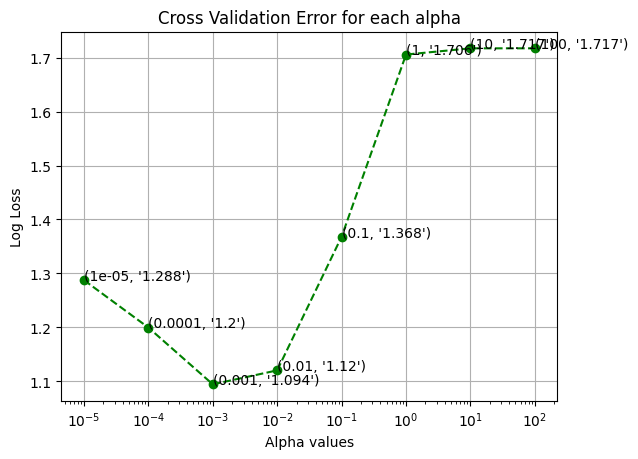

Best Alpha: 0.001
For Train data with alpha=0.001, Log Loss: 0.5908784849033686
For Cross Validation data with alpha=0.001, Log Loss: 1.0697656891677272
For Test data with alpha=0.001, Log Loss: 1.194163868131946


In [109]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Hinge Loss (Linear SVM)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)


    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)


    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g', marker='o', linestyle='dashed')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

# Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]

print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_onehotCoding, train_y),
                           ("Cross Validation", cv_x_onehotCoding, cv_y),
                           ("Test", test_x_onehotCoding, y_test)]:

    predict_y = sig_clf.predict_proba(X)


    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.0944006910378965
Number of mis-classified points : 0.3383458646616541
____________________ Confusion Matrix --------------------


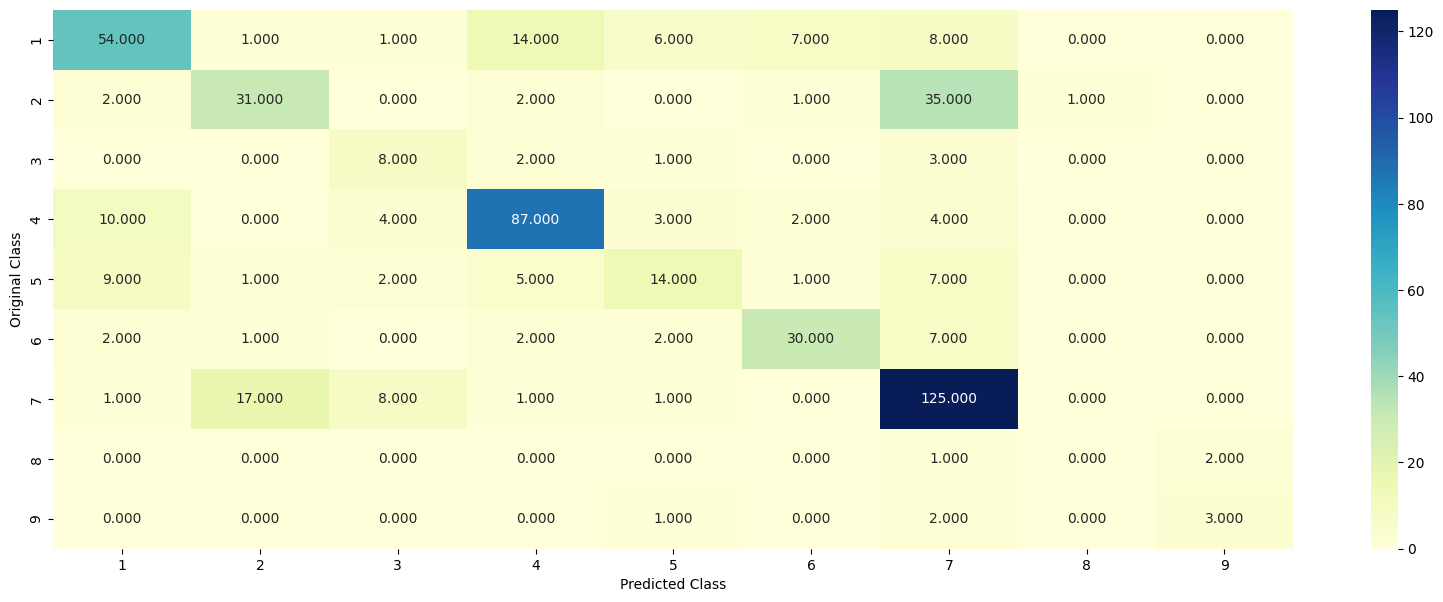

-------------------- Precision matrix (Columm Sum=1) --------------------


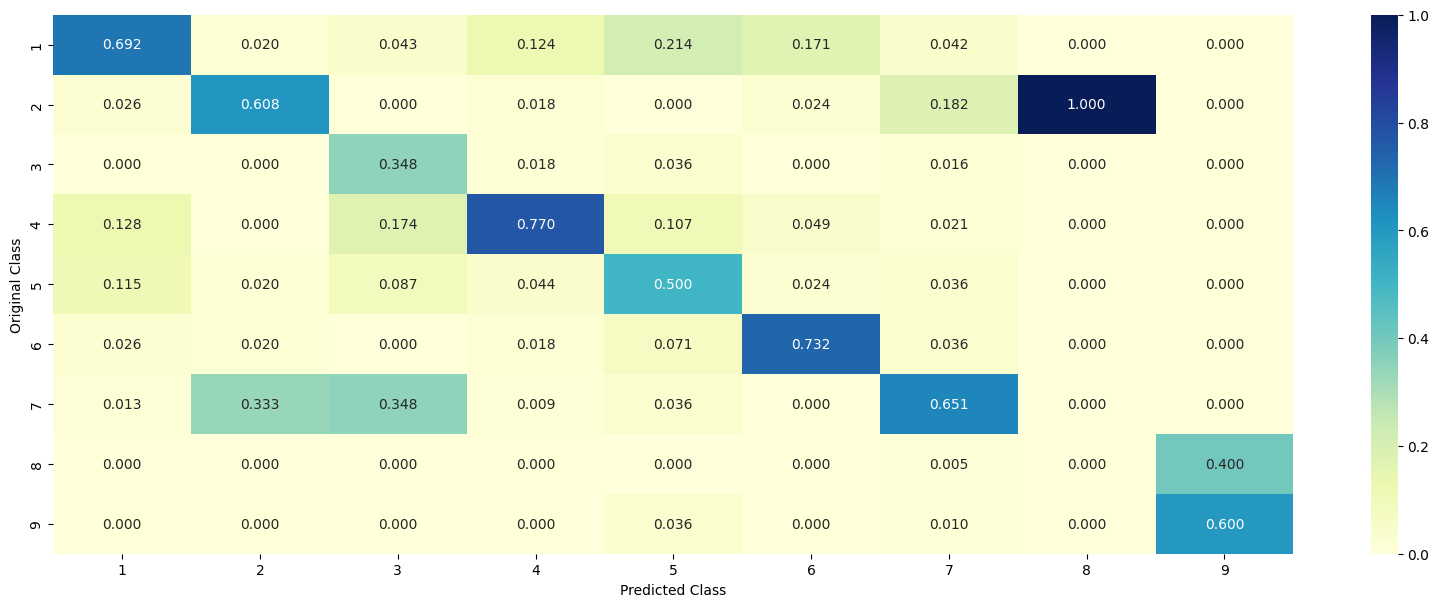

-------------------- Recall matrix (Row sum=1) --------------------


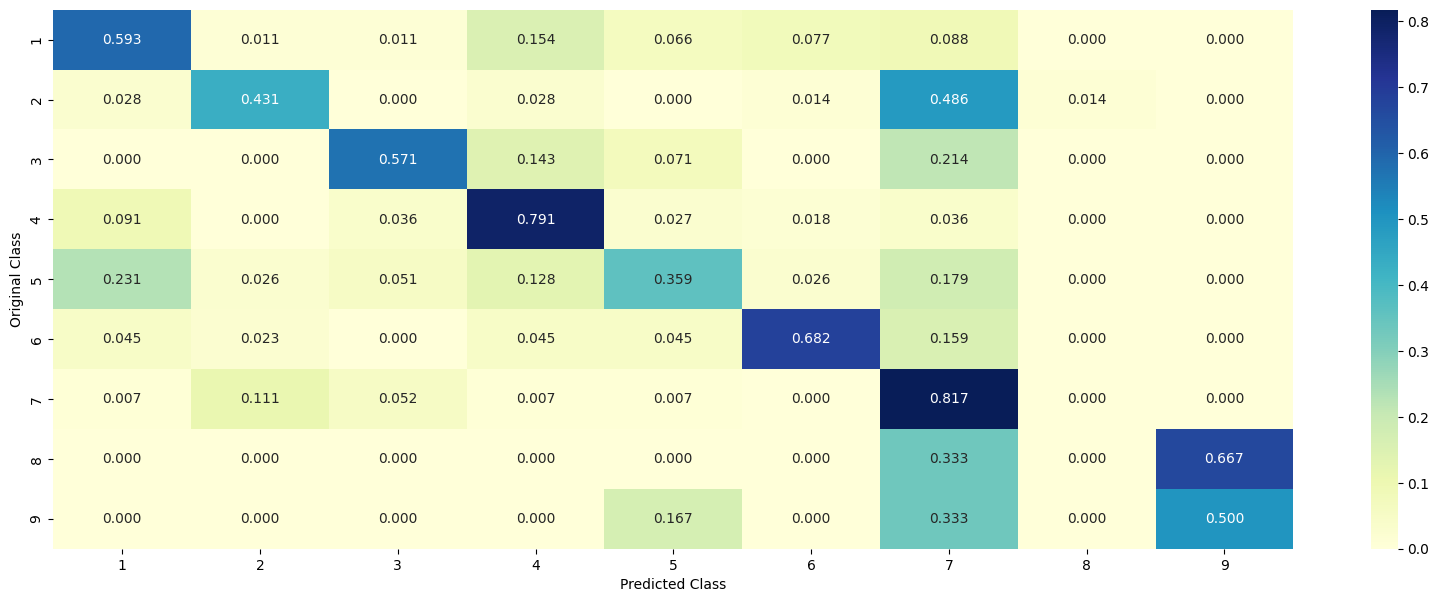

In [111]:
# Testing model with best hyper parameters

clf = SGDClassifier(alpha =best_alpha, penalty ='l2', loss='hinge', random_state = 42, class_weight ='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [114]:
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 6
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]


Predicted Class : 7
Predicted Class Probabilities: [[0.1188 0.0799 0.031  0.1364 0.0617 0.2681 0.2898 0.0069 0.0075]]
Actual Class : 6


In [116]:
test_point_index = 48
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]


Predicted Class : 3
Predicted Class Probabilities: [[0.0651 0.0476 0.6557 0.0426 0.0365 0.0206 0.1204 0.0071 0.0044]]
Actual Class : 3


#### TFIDF Features

For alpha = 1e-05
Log Loss: 1.209989220230429
For alpha = 0.0001
Log Loss: 1.1436771995150299
For alpha = 0.001
Log Loss: 1.0284794483735737
For alpha = 0.01
Log Loss: 1.1096785861910807
For alpha = 0.1
Log Loss: 1.2571683235919817
For alpha = 1
Log Loss: 1.4593179830063676
For alpha = 10
Log Loss: 1.4589928631834712
For alpha = 100
Log Loss: 1.4589928487179629


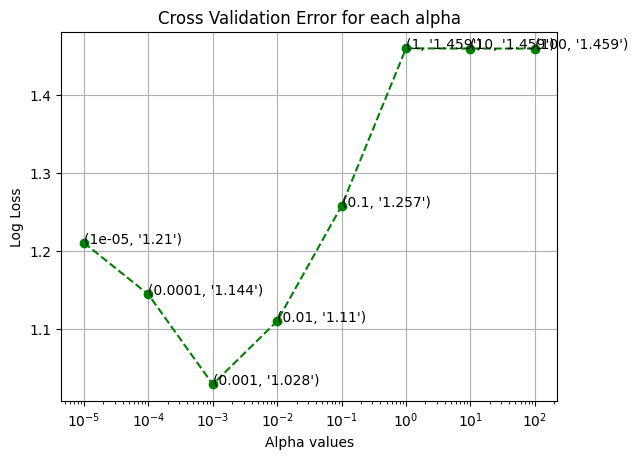

Best Alpha: 0.001
For Train data with alpha=0.001, Log Loss: 0.5259086697393505
For Cross Validation data with alpha=0.001, Log Loss: 1.0284794483735737
For Test data with alpha=0.001, Log Loss: 1.14501684820669


In [117]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Hinge Loss (Linear SVM)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf)


    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)


    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g', marker='o', linestyle='dashed')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

# Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]

print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf, train_y),
                           ("Cross Validation", cv_tfidf, cv_y),
                           ("Test", test_tfidf, y_test)]:

    predict_y = sig_clf.predict_proba(X)


    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")


Log loss : 1.14501684820669
Number of mis-classified points : 0.36541353383458647
____________________ Confusion Matrix --------------------


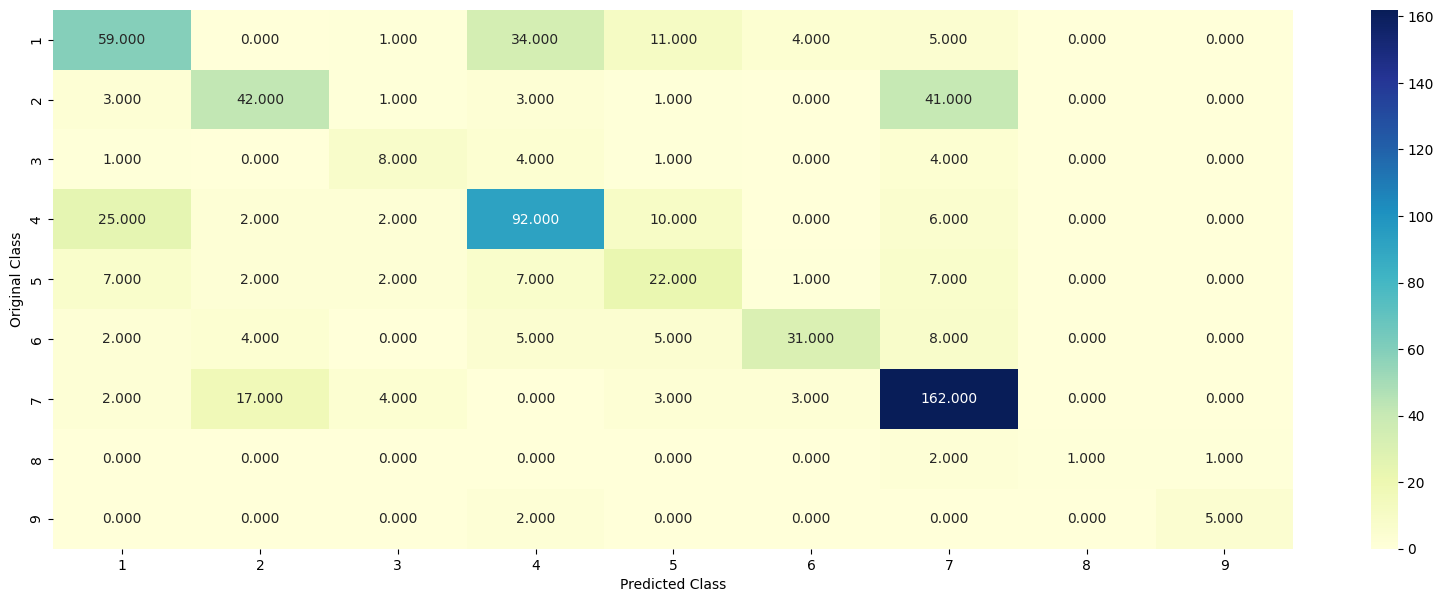

-------------------- Precision matrix (Columm Sum=1) --------------------


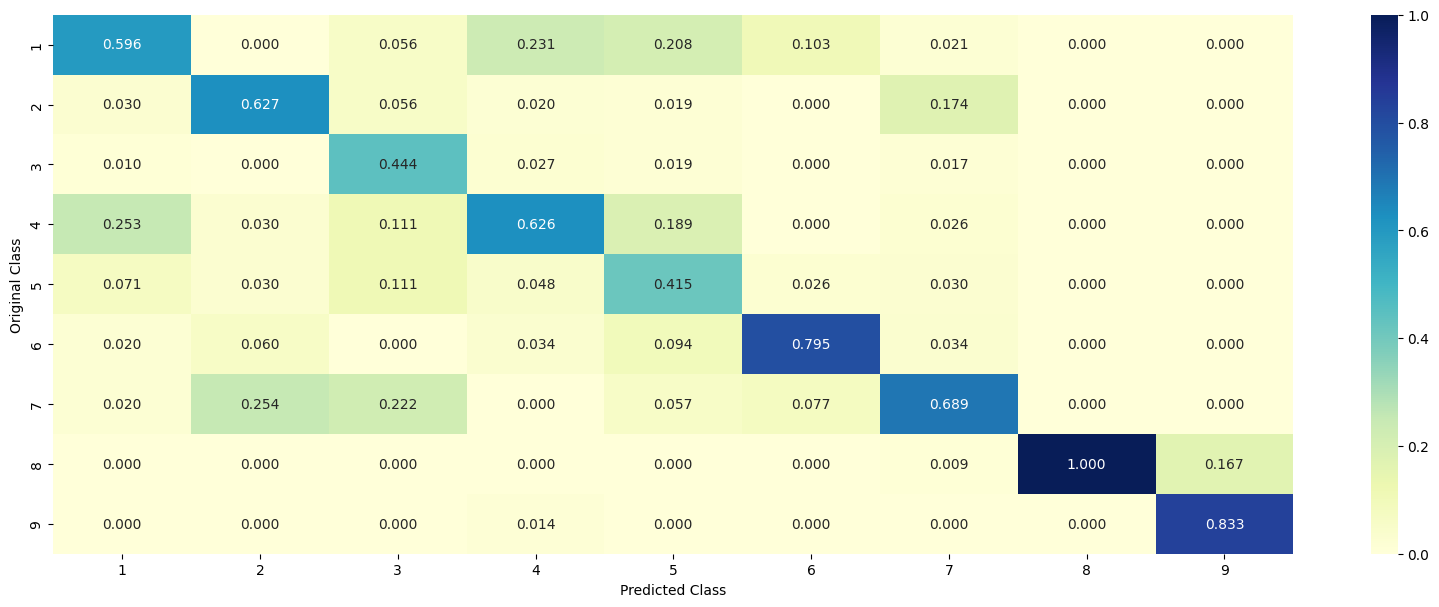

-------------------- Recall matrix (Row sum=1) --------------------


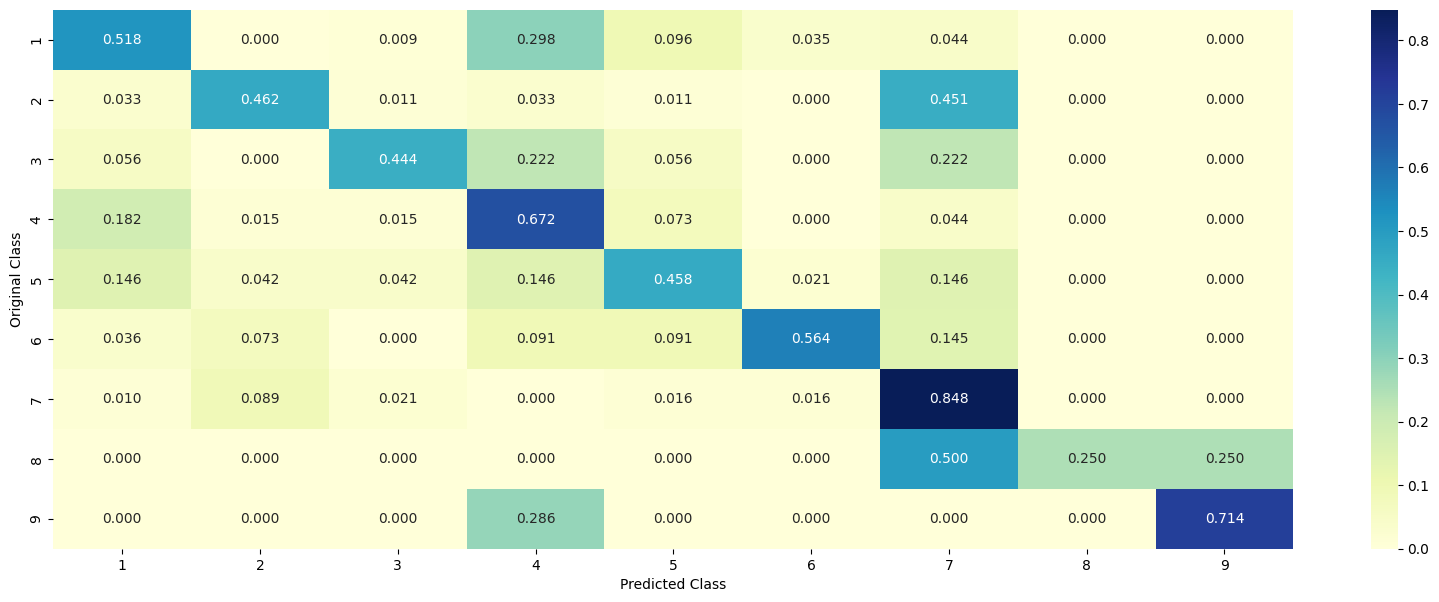

In [118]:

clf = SGDClassifier(alpha =best_alpha, penalty ='l2', loss='hinge', random_state = 42, class_weight ='balanced')
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_tfidf, test_y, clf)

#### TFIDF with top 1000 features

For alpha = 1e-05
Log Loss: 1.050804930976379
For alpha = 0.0001
Log Loss: 1.0023401937202352
For alpha = 0.001
Log Loss: 1.0386508314760678
For alpha = 0.01
Log Loss: 1.315811691334929
For alpha = 0.1
Log Loss: 1.6275130909700821
For alpha = 1
Log Loss: 1.7512678501093777
For alpha = 10
Log Loss: 1.7512678574079967
For alpha = 100
Log Loss: 1.7512678574292064


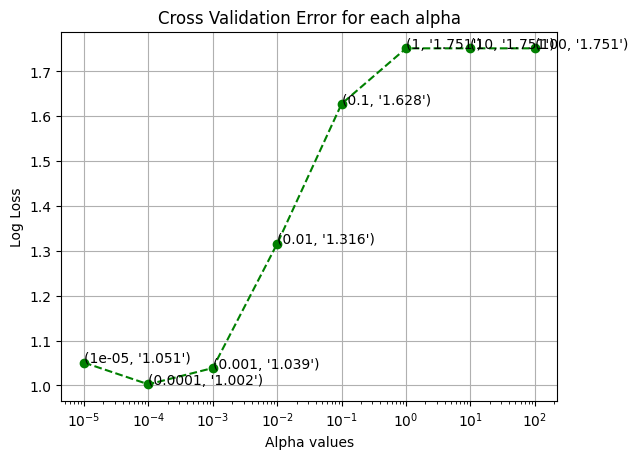

Best Alpha: 0.0001
For Train data with alpha=0.0001, Log Loss: 0.3275517668798365
For Cross Validation data with alpha=0.0001, Log Loss: 1.0023401937202352
For Test data with alpha=0.0001, Log Loss: 1.0770297391268844


In [119]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Hinge Loss (Linear SVM)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf_maxft, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf_maxft, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_maxft)


    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)


    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g', marker='o', linestyle='dashed')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

# Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]

print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf_maxft, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf_maxft, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf_maxft, train_y),
                           ("Cross Validation", cv_tfidf_maxft, cv_y),
                           ("Test", test_tfidf_maxft, y_test)]:

    predict_y = sig_clf.predict_proba(X)


    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.0770297391268844
Number of mis-classified points : 0.3593984962406015
____________________ Confusion Matrix --------------------


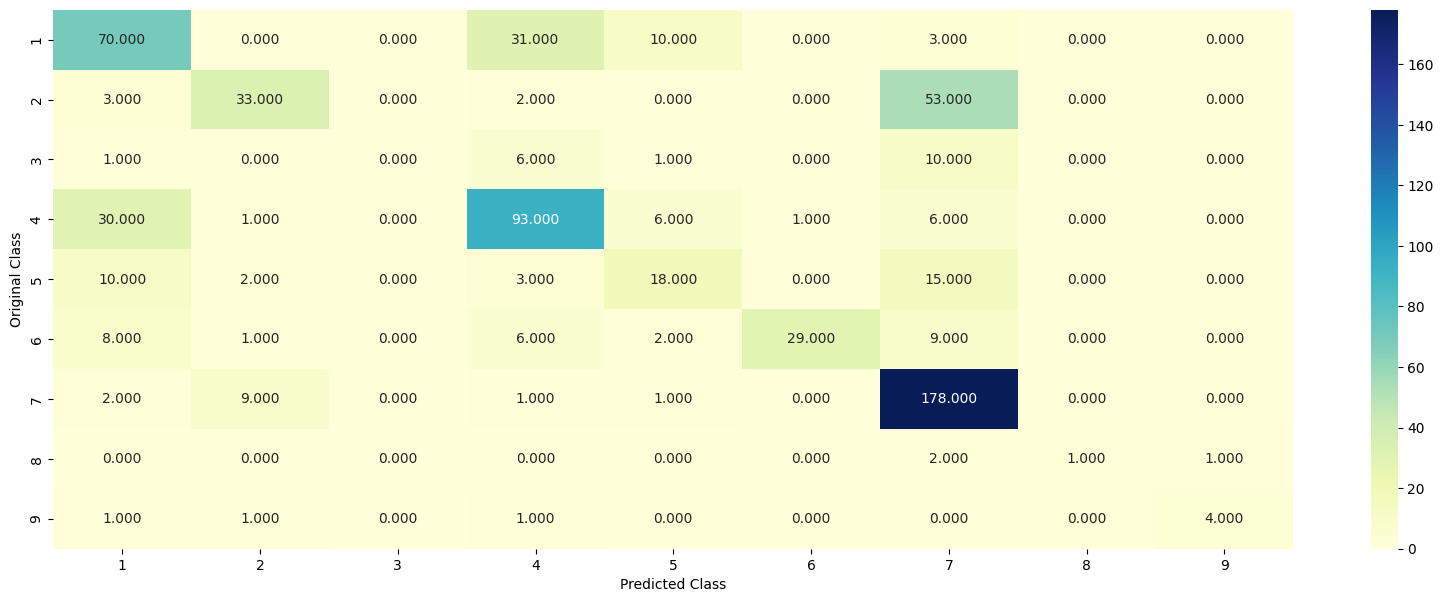

-------------------- Precision matrix (Columm Sum=1) --------------------


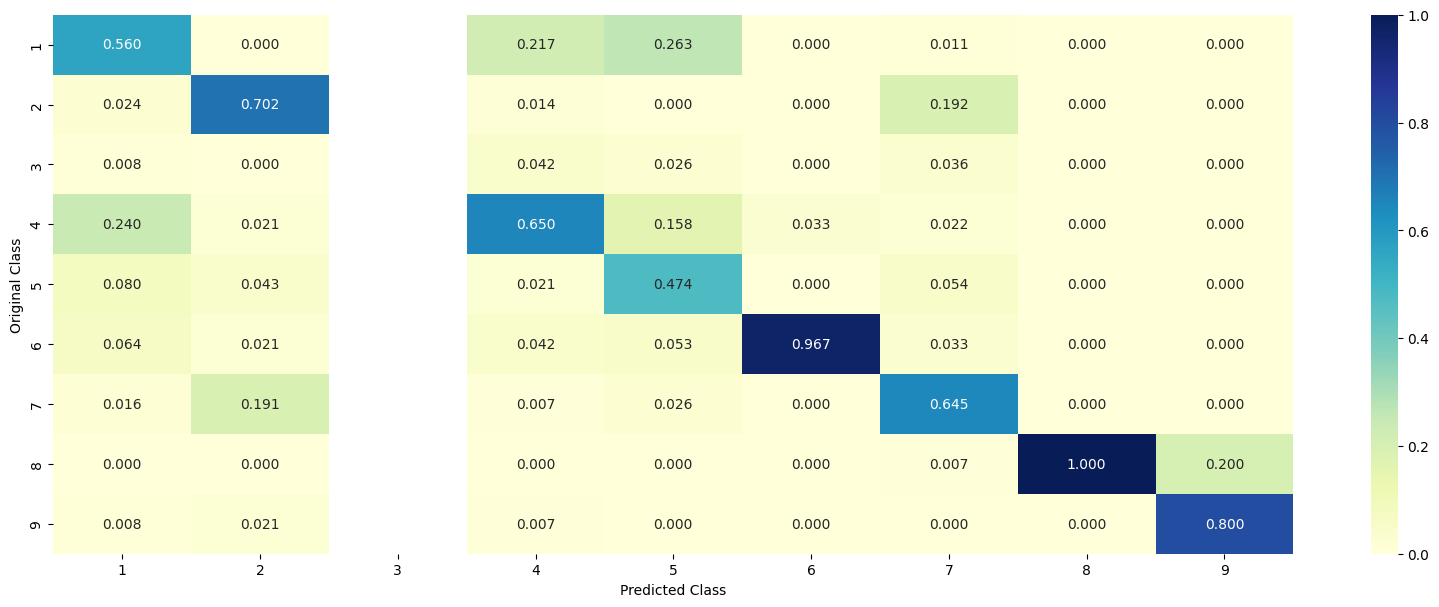

-------------------- Recall matrix (Row sum=1) --------------------


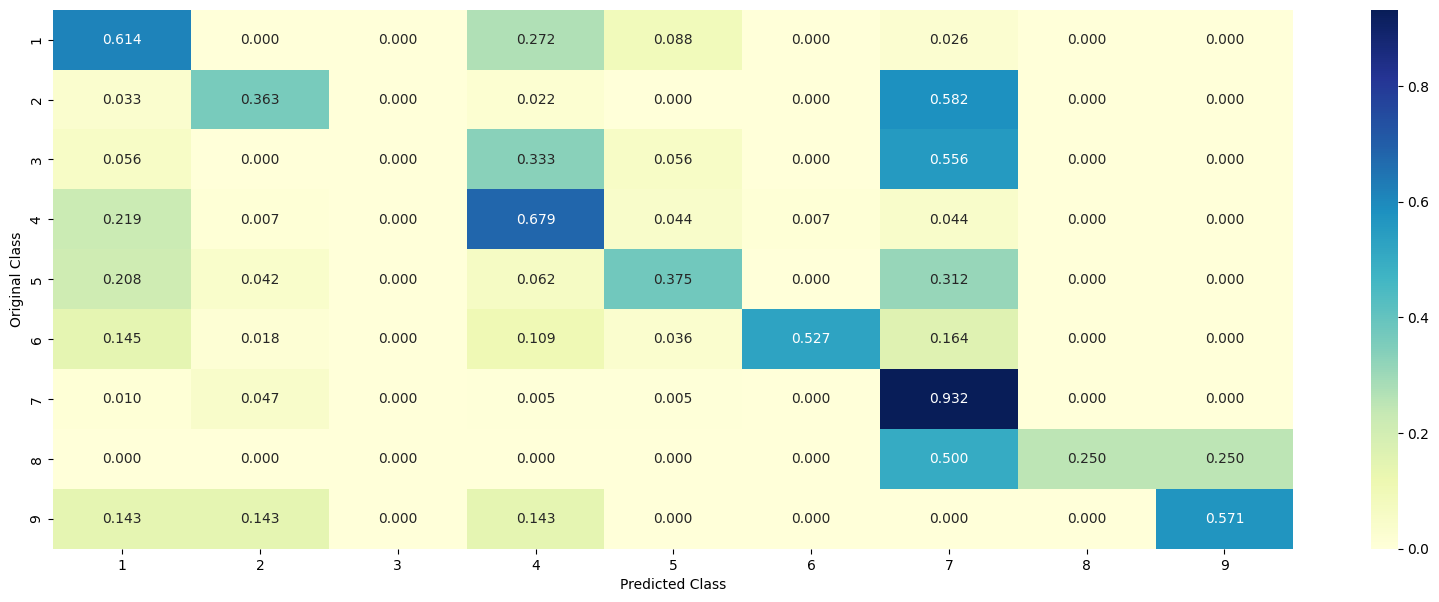

In [120]:
clf = SGDClassifier(alpha =best_alpha, penalty ='l2', loss='hinge', random_state = 42, class_weight ='balanced')
predict_and_plot_confusion_matrix(train_x_tfidf_maxft, train_y, test_tfidf_maxft, test_y, clf)

# Random Forest Classifier

## Hyper parameter tuning(One hot encoding)

In [122]:
alphas = [100,200,500,1000,2000]
max_depth_values = [5, 10]
cv_log_error_array = []
param_combinations = []  # Store (n_estimators, max_depth) pairs

# Loop through different hyperparameters
for n_estimators in alphas:
    for max_depth in max_depth_values:
        print(f"For n_estimators = {n_estimators}, max_depth = {max_depth}")
        # Train Random Forest Classifier
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion='gini',
                             max_depth=max_depth, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        # Calibrate the classifier
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        # Predict Probabilities on CV Data
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)
        # Compute Log Loss
        log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
        cv_log_error_array.append(log_loss_value)
        param_combinations.append((n_estimators, max_depth))
        print("Log Loss:", log_loss_value)

# Find Best Parameters
best_idx = np.argmin(cv_log_error_array)
best_n_estimators, best_max_depth = param_combinations[best_idx]
print(f"Best n_estimators: {best_n_estimators}, Best max_depth: {best_max_depth}")

# Train Model with Best Parameters
clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini',
                             max_depth=best_max_depth, random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_onehotCoding, train_y),
                           ("Cross Validation", cv_x_onehotCoding, cv_y),
                           ("Test", test_x_onehotCoding, y_test)]:

    predict_y = sig_clf.predict_proba(X)

    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with n_estimators={best_n_estimators}, max_depth={best_max_depth}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

For n_estimators = 100, max_depth = 5
Log Loss: 1.2504891581414779
For n_estimators = 100, max_depth = 10
Log Loss: 1.1690795325839858
For n_estimators = 200, max_depth = 5
Log Loss: 1.2456676060706289
For n_estimators = 200, max_depth = 10
Log Loss: 1.1624202546450586
For n_estimators = 500, max_depth = 5
Log Loss: 1.2432395226816702
For n_estimators = 500, max_depth = 10
Log Loss: 1.1566080288032603
For n_estimators = 1000, max_depth = 5
Log Loss: 1.2368912695909664
For n_estimators = 1000, max_depth = 10
Log Loss: 1.1572548470144222
For n_estimators = 2000, max_depth = 5
Log Loss: 1.2342604504032275
For n_estimators = 2000, max_depth = 10
Log Loss: 1.1578941266851912
Best n_estimators: 500, Best max_depth: 10
For Train data with n_estimators=500, max_depth=10, Log Loss: 0.6971736092128769
For Cross Validation data with n_estimators=500, max_depth=10, Log Loss: 1.1566080288032603
For Test data with n_estimators=500, max_depth=10, Log Loss: 1.1944668186529384


Log loss : 1.1944668186529384
Number of mis-classified points : 0.41353383458646614
____________________ Confusion Matrix --------------------


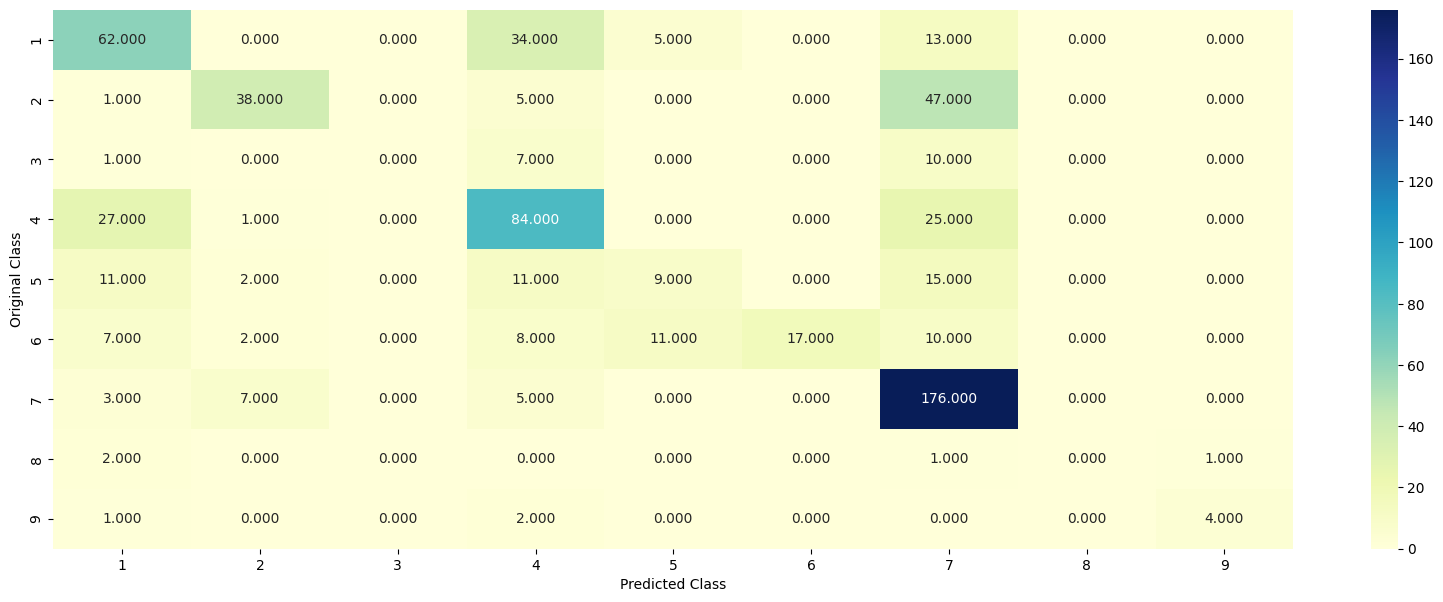

-------------------- Precision matrix (Columm Sum=1) --------------------


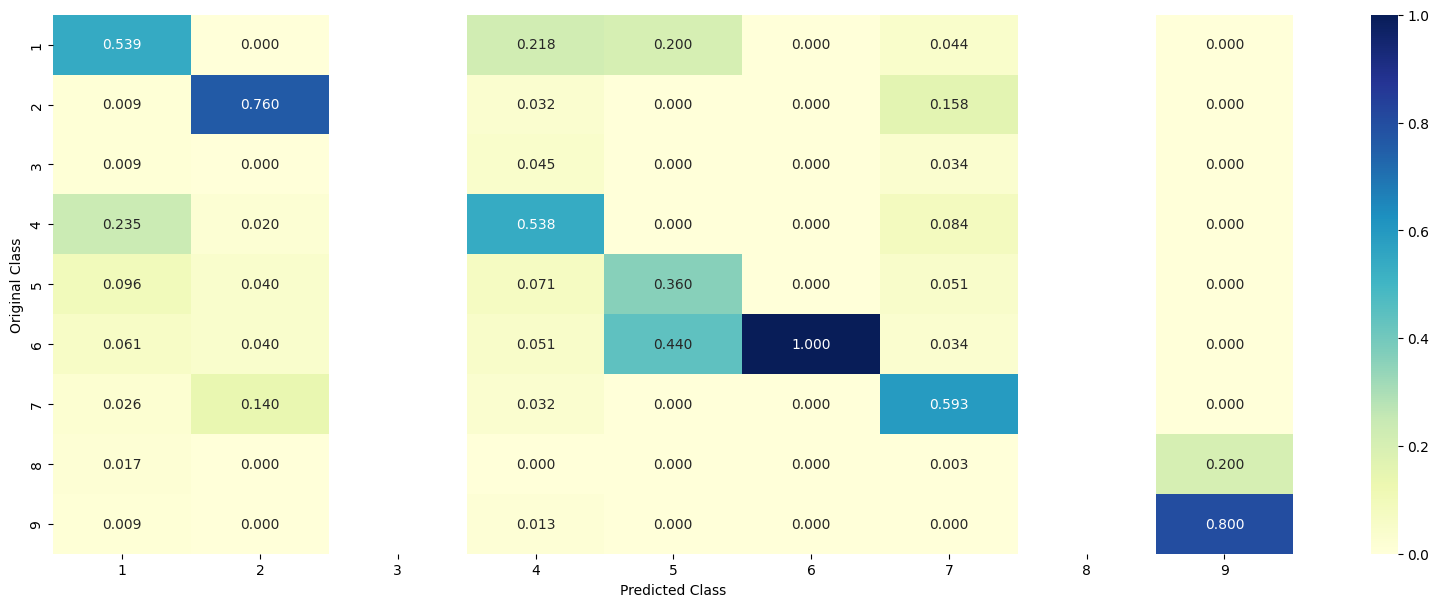

-------------------- Recall matrix (Row sum=1) --------------------


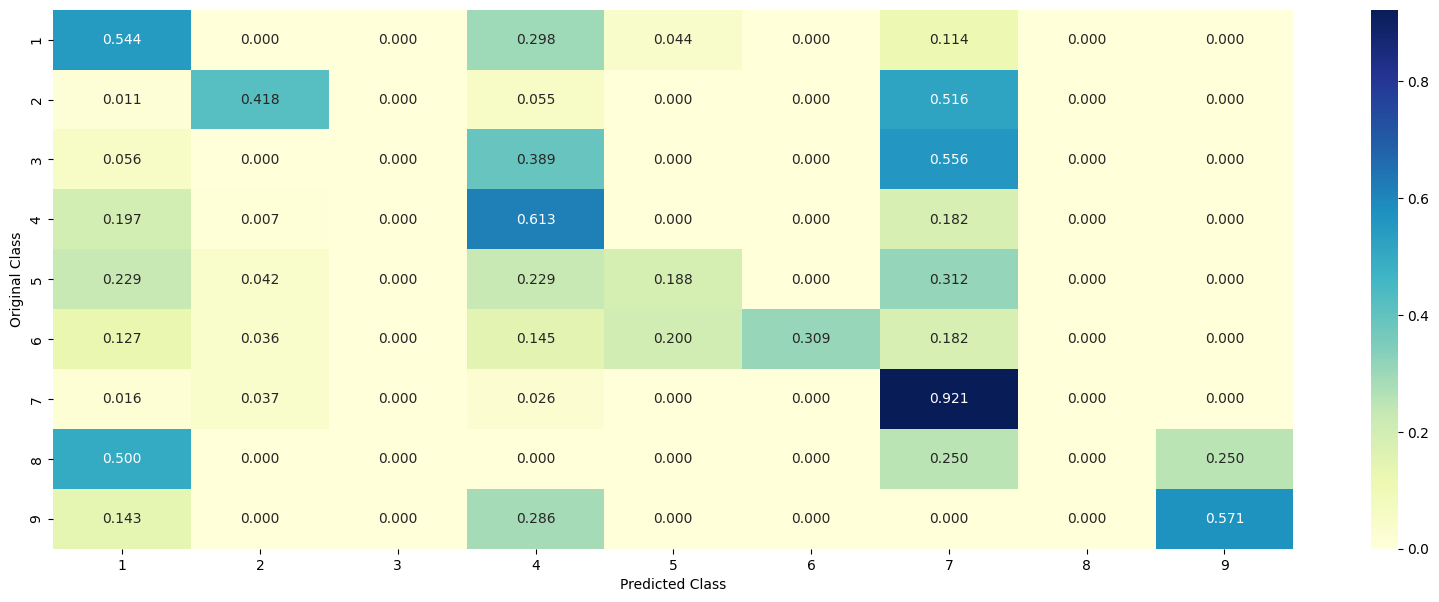

In [125]:
# Testing model with best hyper parameters (One Hot Encoding)

clf = RandomForestClassifier(n_estimators=best_n_estimators,
                             criterion='gini',
                             max_depth=best_max_depth,
                             random_state=42,
                             n_jobs=1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,test_x_onehotCoding,test_y, clf)

In [128]:
clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini', max_depth=best_max_depth, random_state=42, n_jobs=1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)


Predicted Class : 1
Predicted Class Probabilities: [[0.2702 0.1688 0.028  0.1949 0.0637 0.0579 0.1949 0.0097 0.0119]]
Actual Class : 6


In [129]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)


Predicted Class : 4
Predicted Class Probabilities: [[0.1398 0.0145 0.0394 0.6503 0.0867 0.0372 0.0223 0.0047 0.0051]]
Actuall Class : 4
--------------------------------------------------


#### TFIDF Features

In [ ]:
alphas = [100,200,500,1000,2000]
max_depth_values = [5, 10]
cv_log_error_array = []
param_combinations = []  # Store (n_estimators, max_depth) pairs

# Loop through different hyperparameters
for n_estimators in alphas:
    for max_depth in max_depth_values:
        print(f"For n_estimators = {n_estimators}, max_depth = {max_depth}")
        # Train Random Forest Classifier
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion='gini',
                             max_depth=max_depth, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf, train_y)
        # Calibrate the classifier
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf, train_y)
        # Predict Probabilities on CV Data
        sig_clf_probs = sig_clf.predict_proba(cv_tfidf)
        sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)
        # Compute Log Loss
        log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
        cv_log_error_array.append(log_loss_value)
        param_combinations.append((n_estimators, max_depth))
        print("Log Loss:", log_loss_value)

# Find Best Parameters
best_idx = np.argmin(cv_log_error_array)
best_n_estimators, best_max_depth = param_combinations[best_idx]
print(f"Best n_estimators: {best_n_estimators}, Best max_depth: {best_max_depth}")

# Train Model with Best Parameters
clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini',
                             max_depth=best_max_depth, random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf, train_y),
                           ("Cross Validation", cv_tfidf, cv_y),
                           ("Test", test_tfidf, y_test)]:

    predict_y = sig_clf.predict_proba(X)

    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with n_estimators={best_n_estimators}, max_depth={best_max_depth}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

For n_estimators = 100, max_depth = 5
Log Loss: 1.2518805465552696
For n_estimators = 100, max_depth = 10
Log Loss: 1.1716854699199541
For n_estimators = 200, max_depth = 5
Log Loss: 1.2316617036864277
For n_estimators = 200, max_depth = 10
Log Loss: 1.1589737999523977
For n_estimators = 500, max_depth = 5
Log Loss: 1.215900546137149
For n_estimators = 500, max_depth = 10
Log Loss: 1.149310084128062
For n_estimators = 1000, max_depth = 5
Log Loss: 1.2116514054057523
For n_estimators = 1000, max_depth = 10
Log Loss: 1.1504275252207268
For n_estimators = 2000, max_depth = 5
Log Loss: 1.209816036730695
For n_estimators = 2000, max_depth = 10
Log Loss: 1.1500674310012329
Best n_estimators: 500, Best max_depth: 10
For Train data with n_estimators=500, max_depth=10, Log Loss: 0.6511421834009045
For Cross Validation data with n_estimators=500, max_depth=10, Log Loss: 1.149310084128062
For Test data with n_estimators=500, max_depth=10, Log Loss: 1.1304801458420504


Log loss : 1.1304801458420504
Number of mis-classified points : 0.3894736842105263
____________________ Confusion Matrix --------------------


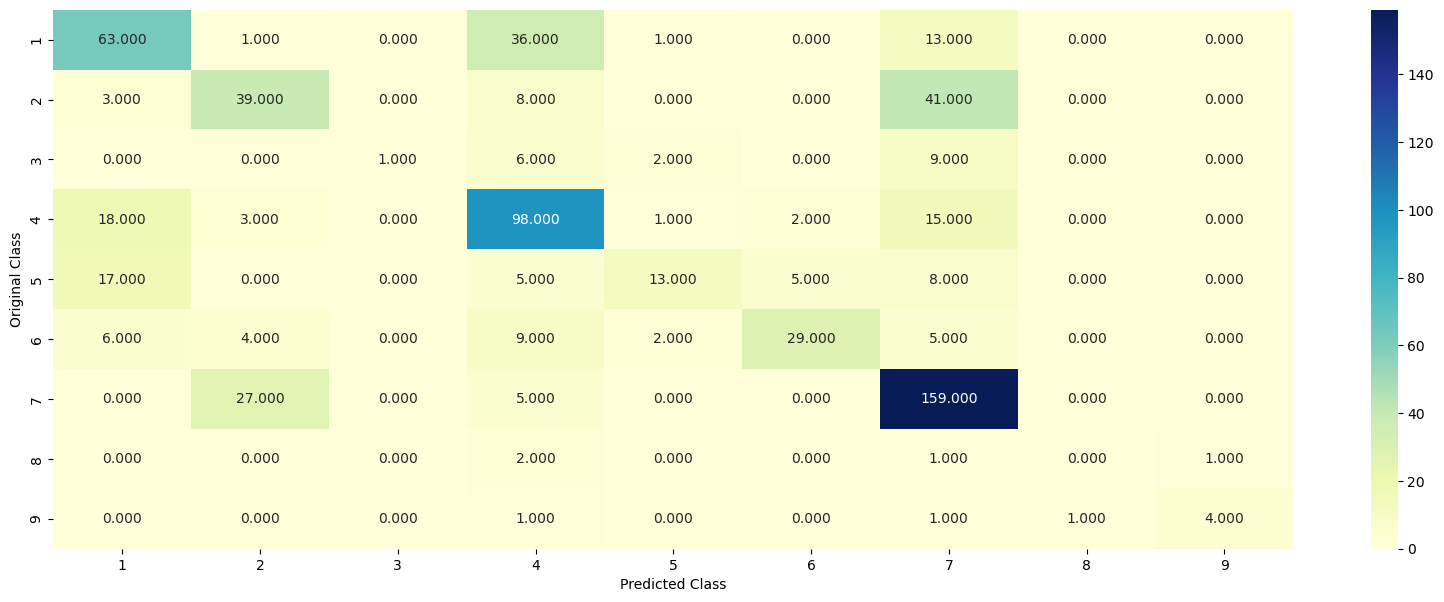

-------------------- Precision matrix (Columm Sum=1) --------------------


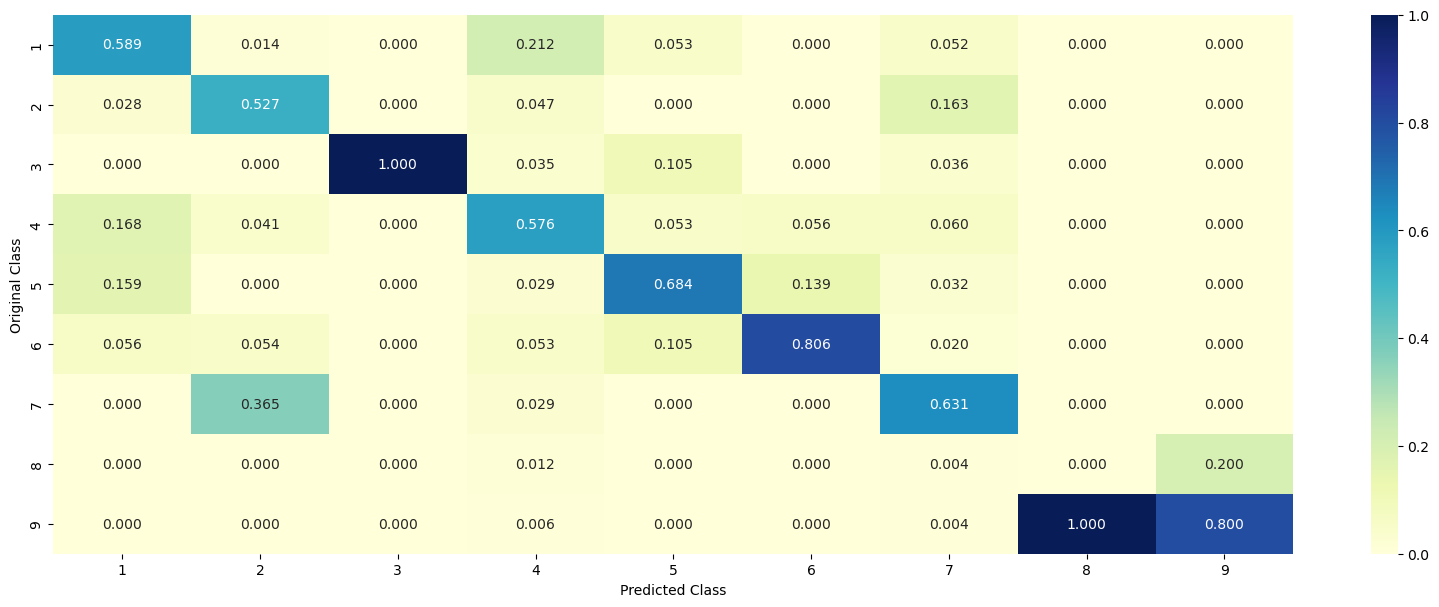

-------------------- Recall matrix (Row sum=1) --------------------


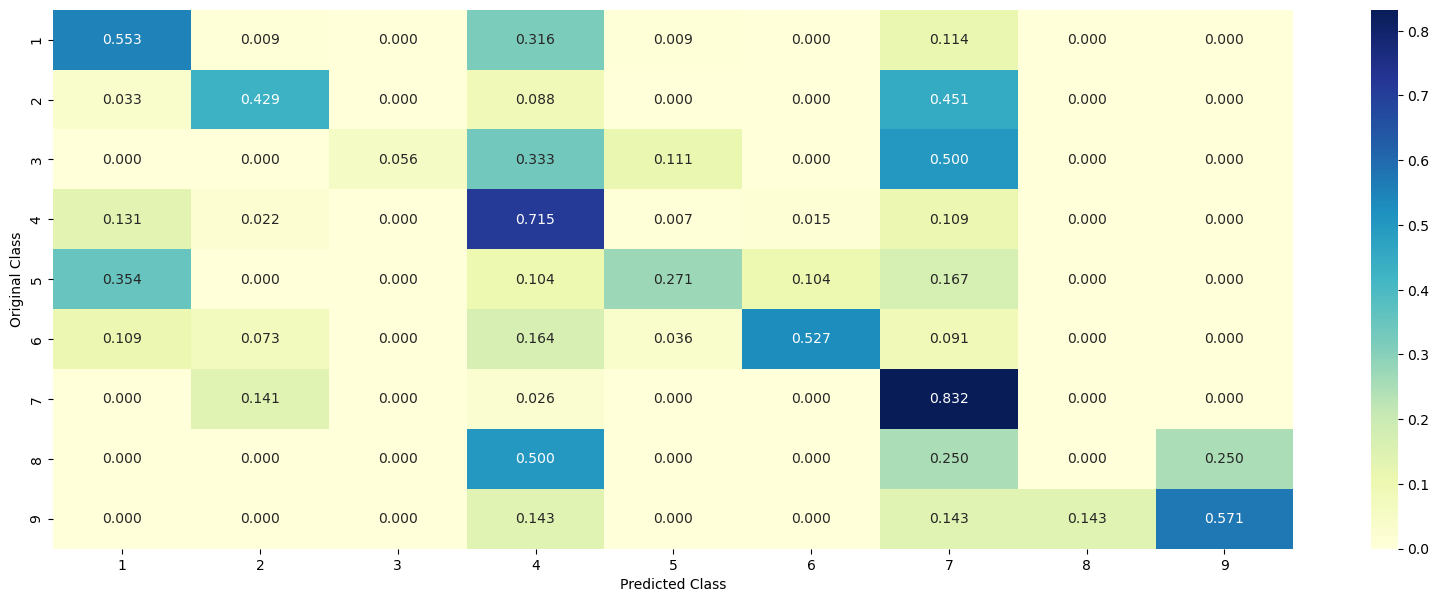

In [ ]:
clf = RandomForestClassifier(n_estimators=best_n_estimators,
                             criterion='gini',
                             max_depth=best_max_depth,
                             random_state=42,
                             n_jobs=1)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y,test_tfidf,test_y, clf)

### TFIDF with top 1000 features

In [ ]:
alphas = [100,200,500,1000,2000]
max_depth_values = [5, 10]
cv_log_error_array = []
param_combinations = []  # Store (n_estimators, max_depth) pairs

# Loop through different hyperparameters
for n_estimators in alphas:
    for max_depth in max_depth_values:
        print(f"For n_estimators = {n_estimators}, max_depth = {max_depth}")
        # Train Random Forest Classifier
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion='gini',
                             max_depth=max_depth, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf_maxft, train_y)
        # Calibrate the classifier
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf_maxft, train_y)
        # Predict Probabilities on CV Data
        sig_clf_probs = sig_clf.predict_proba(cv_tfidf_maxft)
        sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)
        # Compute Log Loss
        log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
        cv_log_error_array.append(log_loss_value)
        param_combinations.append((n_estimators, max_depth))
        print("Log Loss:", log_loss_value)

# Find Best Parameters
best_idx = np.argmin(cv_log_error_array)
best_n_estimators, best_max_depth = param_combinations[best_idx]
print(f"Best n_estimators: {best_n_estimators}, Best max_depth: {best_max_depth}")

# Train Model with Best Parameters
clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini',
                             max_depth=best_max_depth, random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf_maxft, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf_maxft, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf_maxft, train_y),
                           ("Cross Validation", cv_tfidf_maxft, cv_y),
                           ("Test", test_tfidf_maxft, y_test)]:

    predict_y = sig_clf.predict_proba(X)

    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with n_estimators={best_n_estimators}, max_depth={best_max_depth}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

For n_estimators = 100, max_depth = 5
Log Loss: 1.221314525133759
For n_estimators = 100, max_depth = 10
Log Loss: 1.2487895811644225
For n_estimators = 200, max_depth = 5
Log Loss: 1.2173490599647039
For n_estimators = 200, max_depth = 10
Log Loss: 1.2360194003405343
For n_estimators = 500, max_depth = 5
Log Loss: 1.2148149337310565
For n_estimators = 500, max_depth = 10
Log Loss: 1.2349468031242532
For n_estimators = 1000, max_depth = 5
Log Loss: 1.2116807285899172
For n_estimators = 1000, max_depth = 10
Log Loss: 1.2311579664871004
For n_estimators = 2000, max_depth = 5
Log Loss: 1.2126598245376365
For n_estimators = 2000, max_depth = 10
Log Loss: 1.2314737262297082
Best n_estimators: 1000, Best max_depth: 5
For Train data with n_estimators=1000, max_depth=5, Log Loss: 0.8608168712220825
For Cross Validation data with n_estimators=1000, max_depth=5, Log Loss: 1.2116807285899172
For Test data with n_estimators=1000, max_depth=5, Log Loss: 1.1925776526838106


Log loss : 1.1925776526838103
Number of mis-classified points : 0.44511278195488724
____________________ Confusion Matrix --------------------


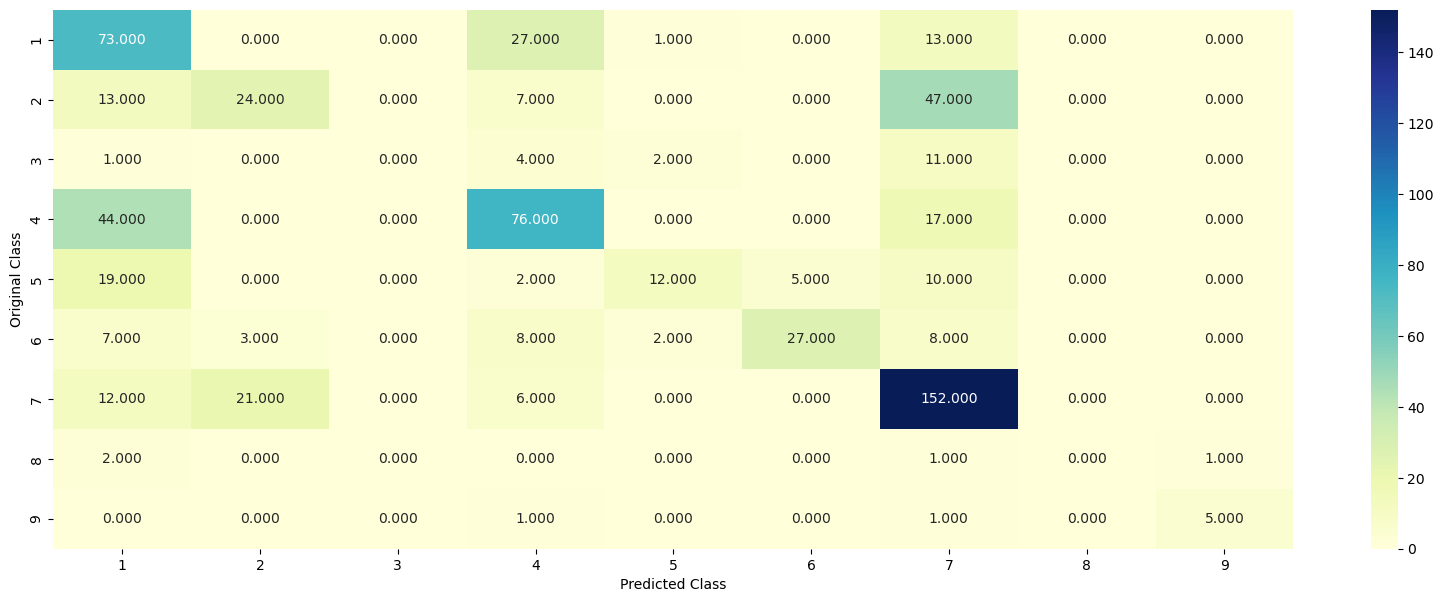

-------------------- Precision matrix (Columm Sum=1) --------------------


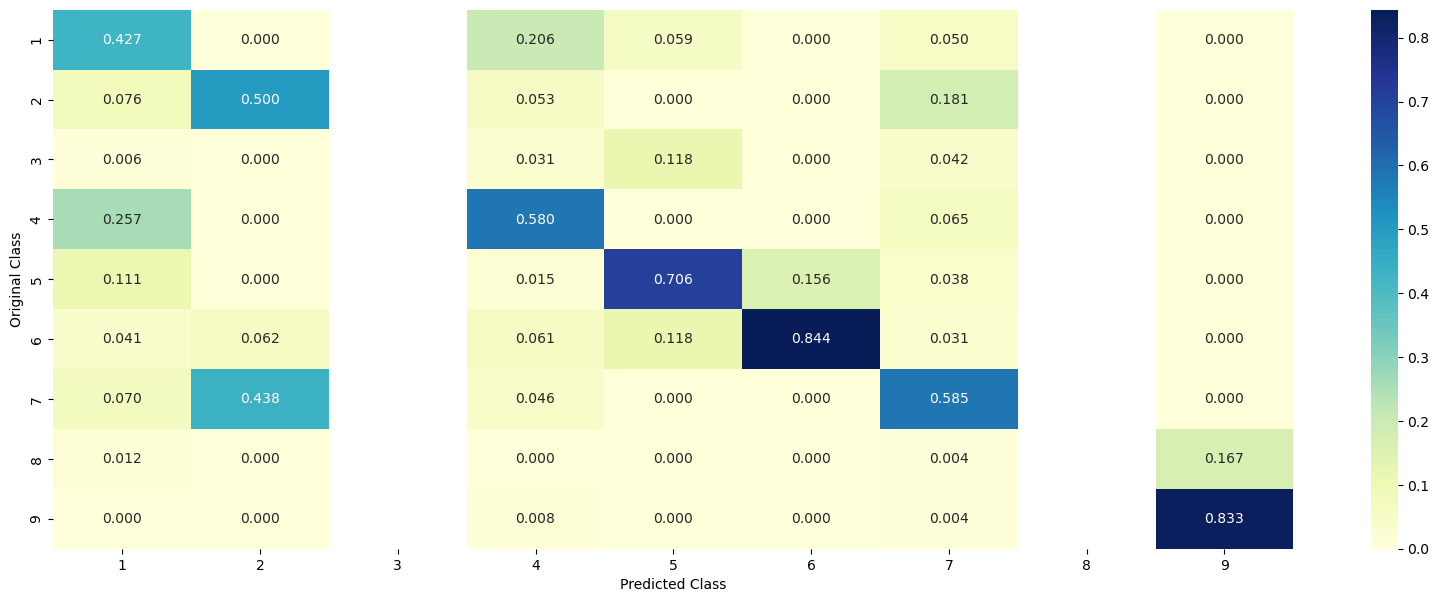

-------------------- Recall matrix (Row sum=1) --------------------


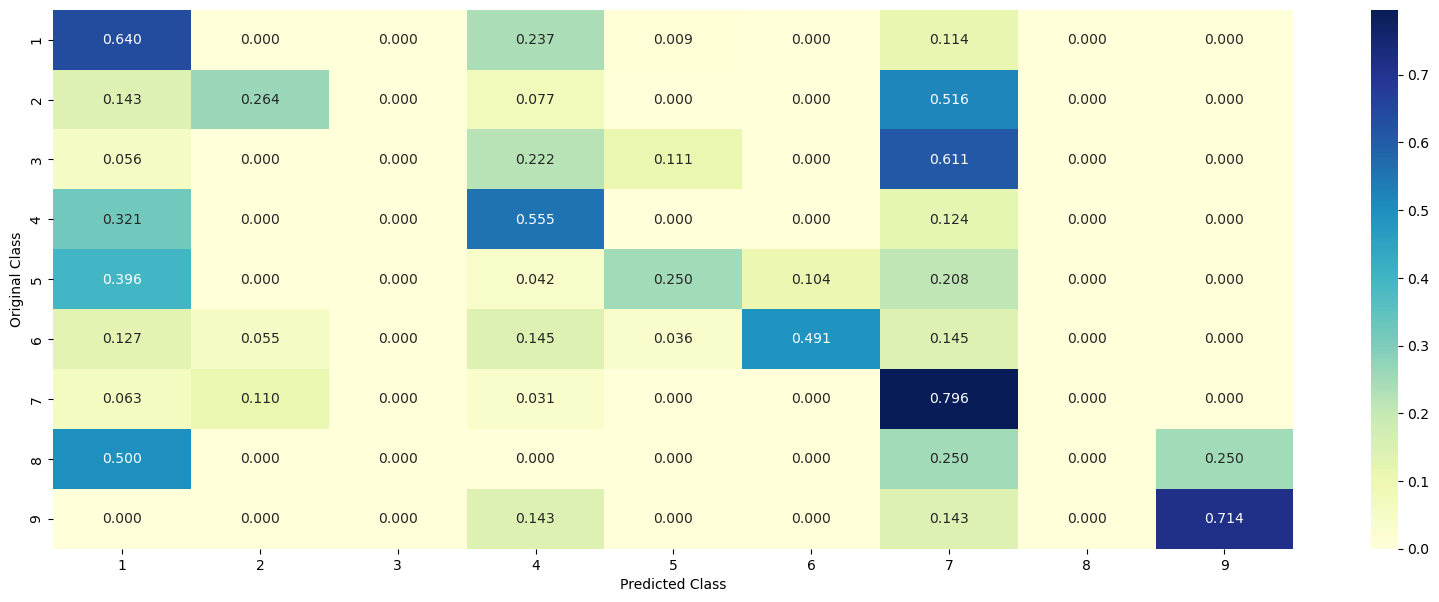

In [ ]:
clf = RandomForestClassifier(n_estimators=best_n_estimators,
                             criterion='gini',
                             max_depth=best_max_depth,
                             random_state=42,
                             n_jobs=1)
predict_and_plot_confusion_matrix(train_x_tfidf_maxft,train_y,test_tfidf_maxft,test_y, clf)